In [1]:
# import necessary packages
import pandas as pd
import numpy as np
import scipy as sp
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

import nltk
from collections import Counter
from string import punctuation
from PIL import Image
import random
from wordcloud import WordCloud, STOPWORDS

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.cm as cm
from sklearn.decomposition import PCA
from sklearn import metrics

import re
import nltk.data
nltk.download('punkt')
tokenizer = nltk.data.load('nltk:tokenizers/punkt/english.pickle')
import gensim
from gensim.models import Word2Vec
from gensim.models import word2vec
from gensim.models import Phrases
from gensim.models.keyedvectors import BaseKeyedVectors
import logging

%matplotlib  inline
pal = sns.set_palette(sns.color_palette("OrRd_r", 6))

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/isabelvanzijl/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Data Wrangling

In [2]:
# read in the csv as a dataframe
df_initial = pd.read_csv('epi_r.csv')

In [3]:
# print head of dataframe
df_initial.head()

,title,rating,calories,protein,fat,sodium,#cakeweek,#wasteless,22-minute meals,3-ingredient recipes,...,yellow squash,yogurt,yonkers,yuca,zucchini,cookbooks,leftovers,snack,snack week,turkey
0,"Lentil, Apple, and Turkey Wrap",2.500,426.0,30.0,7.0,559.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,Boudin Blanc Terrine with Red Onion Confit,4.375,403.0,18.0,23.0,1439.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Potato and Fennel Soup Hodge,3.750,165.0,6.0,7.0,165.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Mahi-Mahi in Tomato Olive Sauce,5.000,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Spinach Noodle Casserole,3.125,547.0,20.0,32.0,452.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
# print shape
print('Shape of dataframe:', df_initial.shape)

Shape of dataframe: (20052, 680)


In [5]:
# use .info() to study contents
df_initial.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20052 entries, 0 to 20051
Columns: 680 entries, title to turkey
dtypes: float64(679), object(1)
memory usage: 104.0+ MB


In [6]:
# all rows and columns are populated, np.NaN where appropriate

In [7]:
# for formatting purposes and matching columns with the categories we extract next,
#    convert titles to title format

# initiate new list to contain column headers in title format
new_cols = [col.title() for col in df_initial.columns]
    
# change the column names
df_initial.columns = new_cols
df_initial.columns

Index(['Title', 'Rating', 'Calories', 'Protein', 'Fat', 'Sodium', '#Cakeweek',
       '#Wasteless', '22-Minute Meals', '3-Ingredient Recipes',
       ...
       'Yellow Squash', 'Yogurt', 'Yonkers', 'Yuca', 'Zucchini', 'Cookbooks',
       'Leftovers', 'Snack', 'Snack Week', 'Turkey'],
      dtype='object', length=680)

In [8]:
# read json file in as a dataframe
rec_df = pd.read_json('full_format_recipes.json', orient='columns')
rec_df.rename(columns ={'date': 'Date Time'}, inplace =True)
rec_df.head()

,calories,categories,Date Time,desc,directions,fat,ingredients,protein,rating,sodium,title
0,426.0,"[Sandwich, Bean, Fruit, Tomato, turkey, Vegeta...",2006-09-01 04:00:00,None,"[1. Place the stock, lentils, celery, carrot, ...",7.0,"[4 cups low-sodium vegetable or chicken stock,...",30.0,2.500,559.0,"Lentil, Apple, and Turkey Wrap"
1,403.0,"[Food Processor, Onion, Pork, Bake, Bastille D...",2004-08-20 04:00:00,This uses the same ingredients found in boudin...,[Combine first 9 ingredients in heavy medium s...,23.0,"[1 1/2 cups whipping cream, 2 medium onions, c...",18.0,4.375,1439.0,Boudin Blanc Terrine with Red Onion Confit
2,165.0,"[Soup/Stew, Dairy, Potato, Vegetable, Fennel, ...",2004-08-20 04:00:00,None,[In a large heavy saucepan cook diced fennel a...,7.0,"[1 fennel bulb (sometimes called anise), stalk...",6.0,3.750,165.0,Potato and Fennel Soup Hodge
3,NaN,"[Fish, Olive, Tomato, Sauté, Low Fat, Low Cal,...",2009-03-27 04:00:00,The Sicilian-style tomato sauce has tons of Me...,[Heat oil in heavy large skillet over medium-h...,NaN,"[2 tablespoons extra-virgin olive oil, 1 cup c...",NaN,5.000,NaN,Mahi-Mahi in Tomato Olive Sauce
4,547.0,"[Cheese, Dairy, Pasta, Vegetable, Side, Bake, ...",2004-08-20 04:00:00,None,[Preheat oven to 350°F. Lightly grease 8x8x2-i...,32.0,"[1 12-ounce package frozen spinach soufflé, th...",20.0,3.125,452.0,Spinach Noodle Casserole


In [9]:
# convert 'date' to a datetime object
pd.to_datetime(rec_df['Date Time'])
rec_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20130 entries, 0 to 20129
Data columns (total 11 columns):
calories       15976 non-null float64
categories     20111 non-null object
Date Time      20111 non-null datetime64[ns]
desc           13495 non-null object
directions     20111 non-null object
fat            15908 non-null float64
ingredients    20111 non-null object
protein        15929 non-null float64
rating         20100 non-null float64
sodium         15974 non-null float64
title          20111 non-null object
dtypes: datetime64[ns](1), float64(5), object(5)
memory usage: 1.8+ MB


### Add Custom Columns

Though not necessarily relevant to the clustering aspect of this project, other data could be useful for our exploratory data analysis.

In [10]:
# Rating Group

# ratings range between 1 to 5, and recipes with no rating have a rating of zero
# put recipes in groupings of 1-2, 2-3, 3-4, 4-5, and null for no rating

# create set_rating_group function
def set_rating_group(rating):
    if rating >= 4:
        return '4-5'
    elif rating >= 3:
        return '3-4'
    elif rating >= 2:
        return '2-3'
    elif rating >= 1:
        return '1-2'
    else:
        return 'no rating'
    
# apply make_humid function
df_initial['Rating Group'] = df_initial['Rating'].apply(set_rating_group)
df_initial.shape

(20052, 681)

In [11]:
# Recipe Identifier

# We want to import the date for each recipe from the json file
# there are fewer rows in our csv file than in our json and there are recipes that
#    have the same title, so we need a unique identifier for each recipe

# create unique identifier in each dataframe
df_initial['Recipe Id'] = df_initial['Title'].map(str) + df_initial['Rating'
                                    ].map(str) + df_initial['Calories'
                                    ].map(str) + df_initial['Protein'].map(str)
rec_df['Recipe Id'] = rec_df['title'].map(str) + rec_df['rating'
                                    ].map(str) + rec_df['calories'
                                    ].map(str) + rec_df['protein'].map(str)

# pull the date column into df_initial based on the Recipe Id
df_initial = df_initial.merge(rec_df.drop_duplicates(subset=['Recipe Id'])[['Recipe Id', 'Date Time']], on='Recipe Id', 
                              how='left', left_index=False)

In [12]:
df_initial.head()

,Title,Rating,Calories,Protein,Fat,Sodium,#Cakeweek,#Wasteless,22-Minute Meals,3-Ingredient Recipes,...,Yuca,Zucchini,Cookbooks,Leftovers,Snack,Snack Week,Turkey,Rating Group,Recipe Id,Date Time
0,"Lentil, Apple, and Turkey Wrap",2.500,426.0,30.0,7.0,559.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2-3,"Lentil, Apple, and Turkey Wrap 2.5426.030.0",2006-09-01 04:00:00
1,Boudin Blanc Terrine with Red Onion Confit,4.375,403.0,18.0,23.0,1439.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4-5,Boudin Blanc Terrine with Red Onion Confit 4.3...,2004-08-20 04:00:00
2,Potato and Fennel Soup Hodge,3.750,165.0,6.0,7.0,165.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3-4,Potato and Fennel Soup Hodge 3.75165.06.0,2004-08-20 04:00:00
3,Mahi-Mahi in Tomato Olive Sauce,5.000,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4-5,Mahi-Mahi in Tomato Olive Sauce 5.0nannan,2009-03-27 04:00:00
4,Spinach Noodle Casserole,3.125,547.0,20.0,32.0,452.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3-4,Spinach Noodle Casserole 3.125547.020.0,2004-08-20 04:00:00


In [13]:
df_initial.shape

(20052, 683)

### Narrow Categories

We need to figure out which of the columns in the csv file are 'categories' and which are 'ingredients'. By extracting what values are listed in categories from the JSON file and comparing them to the strings in the 'ingredients' column of the json, we can get a better list of categories for our analysis.

In [14]:
# extract all categories by appending them to the empty list categories_initial
categories_initial = []
for l in rec_df.categories:
    if type(l) == list:
        for cat in l:
            if cat not in categories_initial:
                categories_initial.append(cat)
                
# format categories
categories_initial = [cat.title() if cat.lower() == cat else cat for cat in categories_initial]                

# sort categories list and check it
categories_initial = sorted(categories_initial)
print('First 40 initial categories:', categories_initial[:40])
print()
print('Number of initial categories:', len(categories_initial))

First 40 initial categories: ['#CAKEWEEK', '#WasteLess', '22-Minute Meals', '3-Ingredient Recipes', '30 Days of Groceries', 'Advance Prep Required', 'Alabama', 'Alaska', 'Alcoholic', 'Almond', 'Amaretto', 'Anchovy', 'Anise', 'Anniversary', 'Anthony Bourdain', 'Aperitif', 'Appetizer', 'Apple', 'Apple Juice', 'Apricot', 'Arizona', 'Artichoke', 'Arugula', 'Asian Pear', 'Asparagus', 'Aspen', 'Atlanta', 'Australia', 'Avocado', 'Back to School', 'Backyard BBQ', 'Bacon', 'Bake', 'Banana', 'Barley', 'Basil', 'Bass', 'Bastille Day', 'Bean', 'Beef']

Number of initial categories: 674


In [15]:
# there are too many categories, mostly due to the fact that ingredients are included as
#    categories. Identify which categories are ingredients by searching for the category 
#    substring in the ingredients list for that recipe

# extract all categories that are ingredients and append them to empty list ingredients_initial
ingredients_initial = []

for i, row in rec_df.iterrows():
    temp_cats = row.categories
    temp_ingr = row.ingredients
    if type(temp_cats) == list and type(temp_ingr) == list:
        for cat in temp_cats:
            cat = cat.lower()
            cat_title = cat.title()
            for ingr in temp_ingr:
                ingr = ingr.lower()
                if ingr.find(cat) != -1 and cat_title not in ingredients_initial:
                    ingredients_initial.append(cat_title)

ingredients_initial = sorted(ingredients_initial)

# print('Ingredients that are categories:', ingredients_initial)
print('Number of ingredients that are categories:', len(ingredients_initial))

Number of ingredients that are categories: 398


In [16]:
# Some ingredients are indeed categories and not ingredients. The initial ingredients 
#    list is easy to scan though, so remove the few categories that exist in it.
# Note: full food items (like Salad and Sandwich) are not ingredients from my perspective

not_ingredients = ['Bake', 'Blender', 'Boil', 'Bon Appétit', 'Braise', 'Breakfast', 'Broil', 
                   'California', 'Cocktail', 'Deep-Fry', 'Dessert', 'Dinner', 'Drink', 'Easter', 
                   'Fall', 'Food Processor', 'Fry', 'Game', 'Gourmet', 'Grill', 'Healthy', 
                   'Ice Cream Machine', 'Juicer', 'Kosher', 'Mandoline', 'Marinate', 'Microwave', 
                   'Mixer', 'Mortar And Pestle', 'New York', 'Passover', 'Pasta Maker', 'Pastry', 
                   'Pie', 'Pizza', 'Poach', 'Pressure Cooker', 'Ramekin', 'Raw', 'Salad', 
                   'Sandwich', 'Sauté', 'Seafood', 'Side', 'Simmer', 'Skewer', 'Slow Cooker', 
                   'Smoker', 'Snack', 'Spring', 'Steam', 'Stew', 'Stir-Fry', 'Summer', 'Tart', 
                   'Thanksgiving', 'Vegan', 'Vegetarian', 'Winter']

# remove items from not_ingredients from the ingredients_initial list
ingredients = [ingr for ingr in ingredients_initial if ingr not in not_ingredients]

# check lengtih of ingredients list to make sure it's less than 398
print('Number of ingredients that are categories:', len(ingredients))

Number of ingredients that are categories: 339


In [17]:
# construct final categories list
# do this by not including categories that appear in the ingredients list
categories = [cat for cat in categories_initial if cat not in ingredients]
#print(categories)
print('Number of categories:', len(categories))

Number of categories: 337


In [18]:
# from our initial dataframe, remove columns (other than title and nutritional info) 
#    that don't fall in the categories list

cols1 = ['Title', 'Rating', 'Rating Group', 'Date Time', 'Calories', 'Protein', 'Fat', 'Sodium']
for cat in categories:
    if cat in df_initial.columns:
        cols1.append(cat)

# create dataframe with only desired columns
df_narrowed = df_initial[cols1]
df_narrowed.head()

,Title,Rating,Rating Group,Date Time,Calories,Protein,Fat,Sodium,22-Minute Meals,3-Ingredient Recipes,...,Washington,"Washington, D.C.",Weelicious,West Virginia,Westwood,Wheat/Gluten-Free,Windsor,Winter,Wisconsin,Yonkers
0,"Lentil, Apple, and Turkey Wrap",2.500,2-3,2006-09-01 04:00:00,426.0,30.0,7.0,559.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Boudin Blanc Terrine with Red Onion Confit,4.375,4-5,2004-08-20 04:00:00,403.0,18.0,23.0,1439.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,Potato and Fennel Soup Hodge,3.750,3-4,2004-08-20 04:00:00,165.0,6.0,7.0,165.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Mahi-Mahi in Tomato Olive Sauce,5.000,4-5,2009-03-27 04:00:00,NaN,NaN,NaN,NaN,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Spinach Noodle Casserole,3.125,3-4,2004-08-20 04:00:00,547.0,20.0,32.0,452.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
df_narrowed.shape

(20052, 318)

### Remove Low Frequency Columns

If some of our categories barely have any recipes falling under them, we should probably exclude them from our analysis.

In [20]:
# exclude columns with 2 or fewer rows that contain them by identifying them in a dict

col_to_remove = dict()
for col in df_narrowed.loc[:,'22-Minute Meals':]:
    if sum(df_narrowed[col]) <= 2:
        col_to_remove[col] = sum(df_narrowed[col])

print('Number of columns with 2 or fewer rows that contain the category:', len(col_to_remove))

Number of columns with 2 or fewer rows that contain the category: 62


In [21]:
# reconstruct list of column names
cols2 = ['Title', 'Rating', 'Rating Group', 'Date Time', 'Calories', 'Protein', 'Fat', 'Sodium']
for col in df_narrowed.loc[:,'22-Minute Meals':].columns:
    if col not in col_to_remove:
        cols2.append(col)

# create dataframe with only desired columns
df_narrowed2 = df_narrowed[cols2]
df_narrowed2.shape

(20052, 256)

### Setup DataFrames and Export CSV Files

In [22]:
# Recipes_Categories

# reassign for future ease of use in final code
df_cats = df_narrowed2

# we already created this dataframe (df_narrowed2) so just need to export
df_cats.to_csv('Recipes_Categories.csv')

In [23]:
# Recipes_Ingredients

# initiate lists of column names
ingr_cols = ['Title', 'Rating', 'Rating Group', 'Date Time', 'Calories', 'Protein', 'Fat', 'Sodium']

# add ingredients to ingr_cols list
for ingr in ingredients:
    if ingr in df_initial.columns:
        ingr_cols.append(ingr)

# create dataframe with only desired columns
df_ingr = df_initial[ingr_cols]

# export to csv
df_ingr.to_csv('Recipes_Ingredients.csv')

In [24]:
# Recipes_Full

# build from the df_narrowed2 but add ingredients
cols_full = cols2 + ingr_cols[8:]

# create dataframe with only desired columns
df_full = df_initial[cols_full]

# export to csv
df_full.to_csv('Recipes_Full.csv')

In [25]:
df_full.head()

,Title,Rating,Rating Group,Date Time,Calories,Protein,Fat,Sodium,22-Minute Meals,3-Ingredient Recipes,...,Whiskey,White Wine,Whole Wheat,Wild Rice,Wine,Wok,Yellow Squash,Yogurt,Yuca,Zucchini
0,"Lentil, Apple, and Turkey Wrap",2.500,2-3,2006-09-01 04:00:00,426.0,30.0,7.0,559.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Boudin Blanc Terrine with Red Onion Confit,4.375,4-5,2004-08-20 04:00:00,403.0,18.0,23.0,1439.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Potato and Fennel Soup Hodge,3.750,3-4,2004-08-20 04:00:00,165.0,6.0,7.0,165.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Mahi-Mahi in Tomato Olive Sauce,5.000,4-5,2009-03-27 04:00:00,NaN,NaN,NaN,NaN,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Spinach Noodle Casserole,3.125,3-4,2004-08-20 04:00:00,547.0,20.0,32.0,452.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20052 entries, 0 to 20051
Columns: 595 entries, Title to Zucchini
dtypes: datetime64[ns](1), float64(592), object(2)
memory usage: 91.2+ MB


# Exploratory Data Analysis

### Nutritional Data

We're provided with data on 'Calories', 'Protein', 'Fat', 'Sodium'. Let's see what the distribution of these variables are and if we can glean any insights from them. We will first study all the data together, and then by rating group to see if there's any variety.

In [27]:
# create nutritional_info list for easy extraction in for loops
nutritional_info = ['Calories', 'Protein', 'Fat', 'Sodium']

# pull summary statistics for nutritional info
df_full.describe()[nutritional_info].round(2)

,Calories,Protein,Fat,Sodium
count,15935.00,15890.00,15869.00,15933.00
mean,6322.96,100.16,346.88,6225.97
std,359046.04,3840.32,20456.11,333318.19
min,0.00,0.00,0.00,0.00
25%,198.00,3.00,7.00,80.00
50%,331.00,8.00,17.00,294.00
75%,586.00,27.00,33.00,711.00
max,30111218.00,236489.00,1722763.00,27675110.00


We have absurdly large max values and standard deviations because of some incorrectly scraped data. Let's look violin plots of our data.

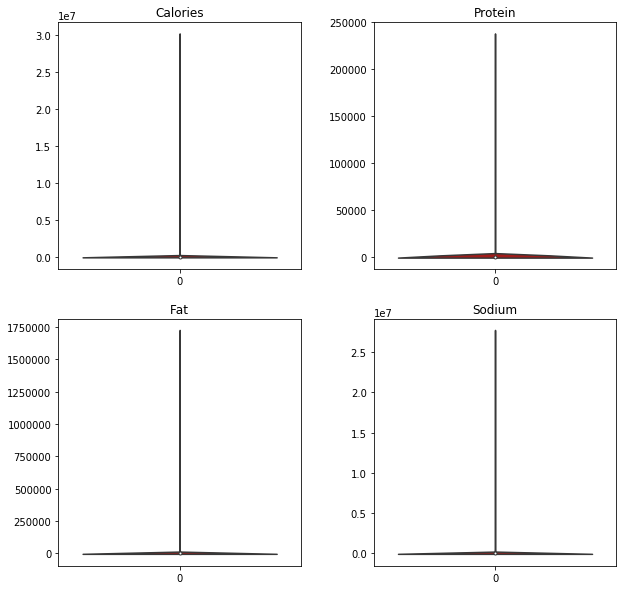

In [28]:
# violin plots for nutritional info
fig = plt.figure()
for k in range(4):    
    ax = fig.add_subplot(2,2,k+1)
    fig.set_figheight(10)
    fig.set_figwidth(10)
    fig.subplots_adjust(wspace=.3)
    
    col = nutritional_info[k]
    sns.violinplot(data = df_full[col], orient='v')
    ax.set_title(nutritional_info[k])
    
# note 'Calories' and 'Sodium' are plotted with scientific notation

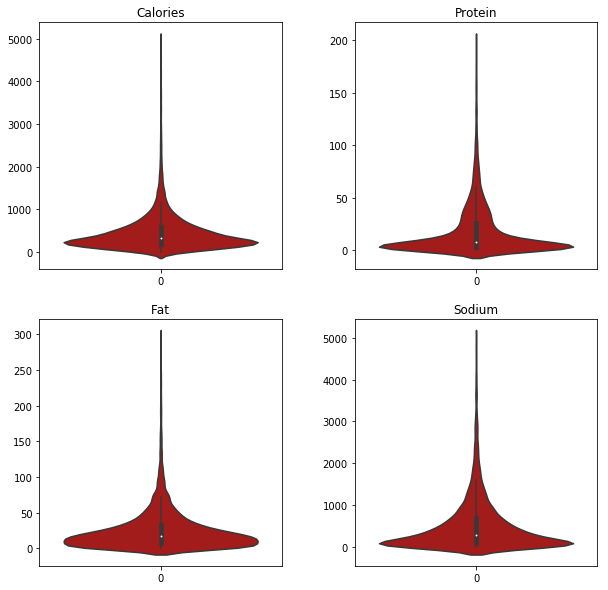

In [29]:
# we shouldn't include these outliers in our analysis

# keep limits in list for easy access
nutr_info_lim = [5000, 200, 300, 5000]

# violin plots for nutritional info
fig = plt.figure()
for k in range(4):    
    ax = fig.add_subplot(2,2,k+1)
    fig.set_figheight(10)
    fig.set_figwidth(10)
    fig.subplots_adjust(wspace=.3)
    
    col = nutritional_info[k]
    sns.violinplot(data = df_full.loc[df_full[col] < nutr_info_lim[k]][col], orient='v')
    ax.set_title(nutritional_info[k])

We can see that a lot of our data is grouped within the 25% and 75% quartiles. Let's see how our data looks split up into rating groupings. This will also solidify what we should set our max limits to.

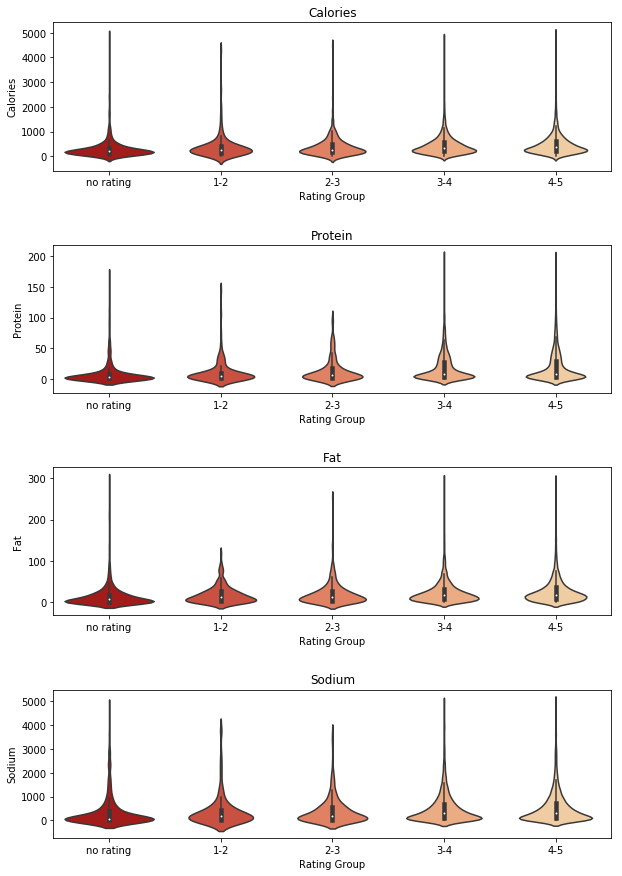

In [30]:
fig = plt.figure()
for k in range(4):    
    ax = fig.add_subplot(4,1,k+1)
    fig.set_figheight(15)
    fig.set_figwidth(10)
    fig.subplots_adjust(hspace=.5)
    
    col = nutritional_info[k]
    sns.violinplot(x='Rating Group', y=col, data=df_full.loc[df_full[col] < nutr_info_lim[k]], 
                   orient='v', order=['no rating', '1-2', '2-3', '3-4', '4-5'])
    ax.set_title(nutritional_info[k])

### Ratings

In [31]:
# retreive summary statistics for ratings
df_full.describe()['Rating']

count    20052.000000
mean         3.714467
std          1.340829
min          0.000000
25%          3.750000
50%          4.375000
75%          4.375000
max          5.000000
Name: Rating, dtype: float64

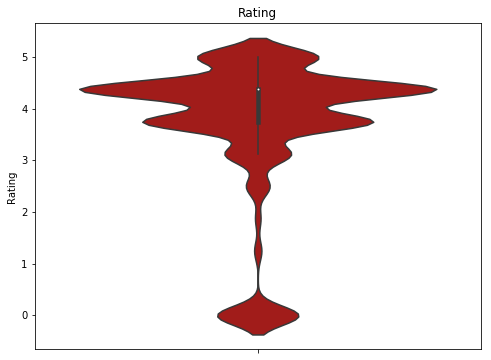

In [32]:
# violin plot for ratings
fig = plt.figure(figsize=(8,6))
fig = sns.violinplot(y='Rating', data=df_full, orient='v')
fig.set_title('Rating')

Most ratings are quite high, or there are no ratings at all. This is a sign that most recipes are enjoyed by Epicurious users. When offering meals in their meal kit service, they should consider just using recipes whose average rating falls above the mean (at least when first starting out the business).

Let's look at the different rating groupings and see how many ratings fall in which groupings

In [33]:
# extract value counts of different rating groups
order = ['no rating', '1-2', '2-3', '3-4', '4-5']
freq_ratgrp = pd.DataFrame(df_full['Rating Group'].value_counts()).reindex(order)
print(freq_ratgrp)

           Rating Group
no rating          1836
1-2                 288
2-3                 532
3-4                6658
4-5               10738


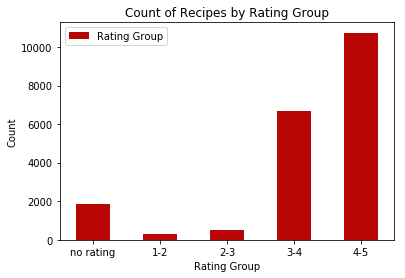

In [34]:
# plot the value counts of different rating groups in a bar graph
fig = plt.figure(figsize=(10,8))
fig = freq_ratgrp.plot(kind='bar')
fig.set_xlabel('Rating Group')
fig.set_ylabel('Count')
fig.set_title('Count of Recipes by Rating Group')
fig = plt.xticks(rotation=0)
plt.show()

### Categories

In [35]:
categories = [cat for cat in df_cats.loc[:,'22-Minute Meals':]]

# calculate how many of each category appears in our dataset
cat_count = df_cats.loc[:,'22-Minute Meals':].sum().reset_index(
    name='count').sort_values('count', ascending=False)
cat_count.head(20)

,index,count
17,Bon Appétit,9355.0
166,Peanut Free,8390.0
214,Soy Free,8088.0
236,Tree Nut Free,7044.0
239,Vegetarian,6846.0
83,Gourmet,6648.0
111,Kosher,6175.0
169,Pescatarian,6042.0
182,Quick & Easy,5372.0
245,Wheat/Gluten-Free,4906.0


**Insights:** Category Groupings

* **Allergies** - There are quite a few categories that are formatted as '(ingredient) less'. Of the most common food allergens (aka 'The Top 8'), five of them are included above.
* **Dietary Restrictions** - People don't eat certain foods for various reasons. Whether it's for religious, animal-welfare, health, or any other reasons, users are looking for recipes that fit their preferences. Note: there is overlap between some of these categories (for example, vegetarians and pescetarians).
* **Seasonal** - This is a category grouping that I wasn't expecting to see, but our outcome suggest that users are interested in eating foods that are in season.
These observations highlight the importance of providing customers with the option to state their dietary restrictions and allergies. Also that it might be useful to provide customers with certain recommendations depending on the season.

I predict that we'll see some clusters emerge based on these category groupings.

In [36]:
# find which categories have highest average rating

# initiate dictionary where keys are categories and values are lists of ratings
# if a recipe is in that category
cats_ratings = {categories[k]: [] for k in range(len(categories))}

# fill the dictionary
for cat in df_cats.loc[:,'22-Minute Meals':].columns:
    for i, row in df_cats.iterrows():
        if row[cat] == 1 and row['Rating'] > 0:
            cats_ratings[cat].append(row['Rating'])

In [37]:
# compute rating averages for each category and insert into new dictionary
avg_cats_ratings = dict()
for key, l in cats_ratings.items():
    if l != []:
        avg_cats_ratings[key] = round(np.mean(l), 2)

# convert dictionary to dataframe and sort by highest average rating
avg_ratings = pd.DataFrame([avg_cats_ratings]).T
avg_ratings.columns = ['Avg Rating']
avg_ratings = avg_ratings.sort_values('Avg Rating', ascending=False)

print('Top 10 Highest Average Ratings:')
print(avg_ratings.head(10))
print()
print('Top 10 Lowest Average Ratings:')
print(avg_ratings.tail(10))

Top 10 Highest Average Ratings:
                 Avg Rating
Rub                    5.00
Cookbook Critic        5.00
Flat Bread             5.00
Brownie                5.00
Cupcake                5.00
Cuba                   5.00
Juicer                 4.79
Kentucky               4.69
Stock                  4.69
Granola                4.69

Top 10 Lowest Average Ratings:
                     Avg Rating
Lancaster                  3.75
Italy                      3.75
Pasta Maker                3.69
Mandoline                  3.69
Aperitif                   3.65
Weelicious                 3.55
Philippines                3.44
Kansas                     3.33
No Meat, No Problem        3.33
Pancake                    2.50


### Ingredients

In [38]:
# find most common ingredients
ingr_count = df_ingr.loc[:,'Almond':].sum().reset_index(
    name='count').sort_values('count', ascending=False)
ingr_count.head(10)

,index,count
200,Onion,2238.0
309,Tomato,2140.0
319,Vegetable,2087.0
116,Fruit,1958.0
106,Egg,1768.0
137,Herb,1681.0
118,Garlic,1643.0
67,Cheese,1355.0
70,Chicken,1344.0
259,Roast,1320.0


In [39]:
# find average number of ingredients per recipe

# calculate row totals for ingredients
df_ingr['Total Ingredients'] = df_ingr.loc[:,'Almond':].sum(axis=1)
df_ingr.head()

/Users/isabelvanzijl/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,Title,Rating,Rating Group,Date Time,Calories,Protein,Fat,Sodium,Almond,Amaretto,...,White Wine,Whole Wheat,Wild Rice,Wine,Wok,Yellow Squash,Yogurt,Yuca,Zucchini,Total Ingredients
0,"Lentil, Apple, and Turkey Wrap",2.500,2-3,2006-09-01 04:00:00,426.0,30.0,7.0,559.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0
1,Boudin Blanc Terrine with Red Onion Confit,4.375,4-5,2004-08-20 04:00:00,403.0,18.0,23.0,1439.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
2,Potato and Fennel Soup Hodge,3.750,3-4,2004-08-20 04:00:00,165.0,6.0,7.0,165.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
3,Mahi-Mahi in Tomato Olive Sauce,5.000,4-5,2009-03-27 04:00:00,NaN,NaN,NaN,NaN,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
4,Spinach Noodle Casserole,3.125,3-4,2004-08-20 04:00:00,547.0,20.0,32.0,452.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0


In [40]:
print('Average number of main ingredients in a recipe:', round(np.mean(df_ingr['Total Ingredients']),0))

Average number of main ingredients in a recipe: 4.0


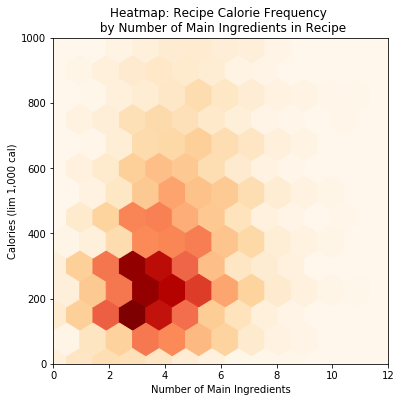

In [41]:
# do higher ratings have noticeable more or fewer ingredients
x = df_ingr.loc[df_ingr['Calories'] < 1500]['Total Ingredients']
y = df_ingr.loc[df_ingr['Calories'] < 1500]['Calories']

fig = plt.figure(figsize=(6,6))
fig = plt.hexbin(x, y, gridsize=19, cmap='OrRd')
fig = plt.ylim(0,1000)
fig = plt.xlim(0,12)
fig = plt.ylabel('Calories (lim 1,000 cal)')
fig = plt.xlabel('Number of Main Ingredients')
fig = plt.title('Heatmap: Recipe Calorie Frequency \n by Number of Main Ingredients in Recipe')
plt.show()

### Recipe Titles

In [42]:
# display top 15 
df_full['Title'].value_counts().head(15)

Pastry Dough            28
Chicken Stock           26
Turkey Giblet Stock     20
Turkey Stock            15
Simple Syrup            13
Salsa Verde             11
Pizza Dough             11
Tomatillo Salsa         10
Pickled Red Onions       9
White Fish Stock         9
Vegetable Stock          8
Corn Bread               8
Avocado Salsa            7
Horseradish Cream        7
French 75                7
Name: Title, dtype: int64

An observation from this list is that many of these common recipe titles aren't for meals, but for a part of a meal. If Epicurious is looking to offer meal kits, they're not going to offer items such as 'Pastry Dough' and 'White Fish Stock' as meals. We will need a way to exclude these recipes from being recommended. They may emerge as their own cluster, but if not, we perhaps will need to filter our recipe titles on ending strings (e.g. 'Dough' and 'Stock' seem to be common ending strings).

The following code builds a wordcloud for some of the keywords in our recipe titles.

In [43]:
t = df_full.Title.apply(nltk.word_tokenize).sum()

In [44]:
def content_text(text):
    stopwords = set(nltk.corpus.stopwords.words('english'))
    without_stp  = Counter()
    for word in text:
        word = word.lower()
        if len(word) < 3:
            continue
        if word not in stopwords:
            without_stp.update([word])
    return [(y,c) for y,c in without_stp.most_common(20)]

without_stop = content_text(t)

(-0.5, 799.5, 1199.5, -0.5)

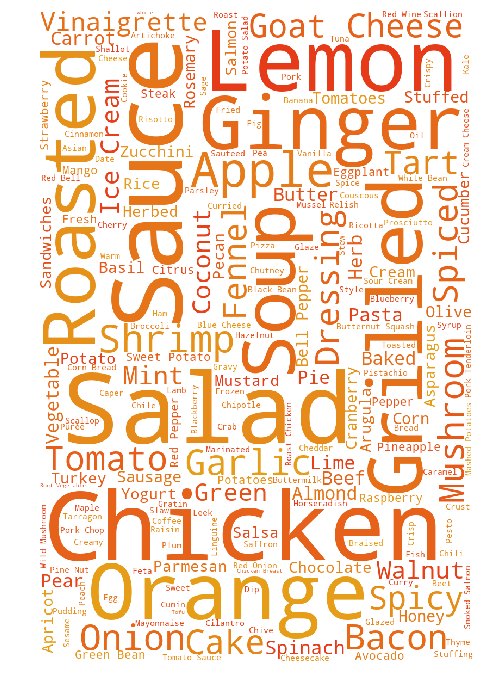

In [45]:
text = ' '.join(t)
stopwords = set(STOPWORDS)

#change the value in return to set the single color need, in hsl format.
def red_color_func(word, font_size, position,orientation,random_state=None, **kwargs):
    return("hsl(%d, 80%%, 50%%)" % np.random.randint(10,40))

wordcloud = WordCloud(width=800, height=1200, background_color='white', max_font_size=180, 
                      stopwords=stopwords, random_state=2, relative_scaling=.5).generate(text)
wordcloud.recolor(color_func = red_color_func)

plt.figure(figsize=(12,12))
plt.imshow(wordcloud)
plt.axis('off')

### Trends Over Time

Have certain types of recipes become more popular in recent years? When do seasonal recipes start to become popular?

In [46]:
# MOST POPULAR CATEGORIES

# create summary table of categoires by year
cat_by_year = df_cats.groupby(pd.to_datetime(df_cats['Date Time']).dt.year)[categories].sum()
cat_by_year = cat_by_year.loc[2005:,:]

In [47]:
# create list of categories that fall in the top 3 categories for the year at least once
# will use this list of categories to take extract from cat_by_year dataframe
top_cats = list()

# iterate through each year and append top categories to top_cats list
for i, row in cat_by_year.iterrows():
    #print(row.index)
    rl = list(row)
    for x in row.nlargest(4):
        index = rl.index(x)
        if categories[index] not in top_cats:
            top_cats.append(categories[index])

top_cats_df = cat_by_year[top_cats]
top_cats_df

,Peanut Free,Soy Free,Gourmet,Quick & Easy,Tree Nut Free,Vegetarian,Bon Appétit,Kosher,Dinner,Kid-Friendly
Date Time,,,,,,,,,,
2005.0,352.0,339.0,315.0,308.0,298.0,253.0,253.0,259.0,79.0,33.0
2006.0,654.0,635.0,423.0,432.0,541.0,540.0,515.0,505.0,98.0,96.0
2007.0,491.0,465.0,328.0,318.0,418.0,409.0,490.0,360.0,143.0,64.0
2008.0,441.0,436.0,271.0,237.0,392.0,291.0,271.0,300.0,272.0,71.0
2009.0,556.0,527.0,248.0,297.0,483.0,340.0,314.0,372.0,389.0,117.0
2010.0,371.0,363.0,48.0,177.0,325.0,242.0,333.0,256.0,211.0,43.0
2011.0,331.0,321.0,42.0,122.0,288.0,215.0,250.0,212.0,178.0,47.0
2012.0,347.0,328.0,80.0,94.0,295.0,272.0,214.0,252.0,138.0,48.0
2013.0,381.0,350.0,30.0,146.0,317.0,258.0,296.0,265.0,207.0,92.0


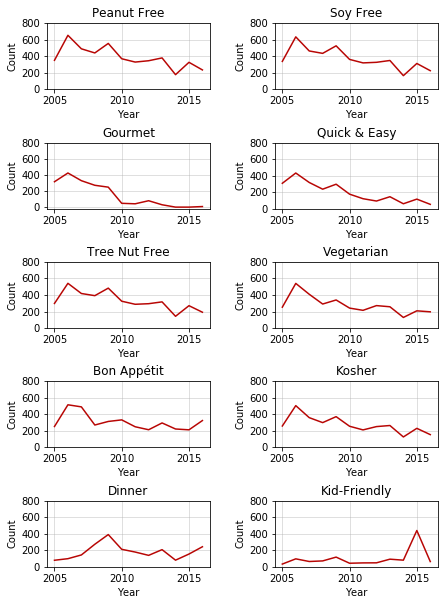

In [48]:
# there are 9 categories. Let's see if any trends stand out.
# plot individually or else graph is too cluttered
fig = plt.figure()
for k in range(len(top_cats)):
    ax = fig.add_subplot(5,2,k+1)
    fig.set_figheight(10)
    fig.set_figwidth(7)
    fig.subplots_adjust(hspace=.8, wspace = .4)
    
    ax.plot(top_cats_df.iloc[:,k])
    plt.setp(ax, yticks=[0, 200, 400, 600, 800], xticks=[2005, 2010, 2015])
    ax.set_xlabel('Year')
    ax.set_ylabel('Count')
    ax.set_title(top_cats[k])
    ax.grid(True, alpha=.5)

Most of our most popular categories have actually been getting less popular in recent years. This could be a sign that the website is slowing down, since these categories above are still the most popular ones in recent years. I do find it interesting that Vegetarian recipes were so popular back in the mid 2000's and seeing a slight decrease, since I assumed it would be a category growing in popularity. Quck & Easy as well as Gourmet have also seen noticeable decreases, perhaps suggesting that users aren't becoming less interested in the type of meal it is but more interested in the ingredients.

One category that did hit a noticeable spike in recent years is Kid-Friedly recipes. I'm going to assume that if there's a large supply of Kid-Friendly recipes, there's probably a large demand. I think this is a reflection on Epicurious' user base. In the 2000's, most of their users were likely people in their 20's and 30's. People that were young enough to understand how to use Technology but still old enough to show an overall interest in cooking compared to younger generations. By 2015, these users were the ones that had kids they needed to feed and therefore were interested in Kid-Friendly recipes. I think it's important to know that this is Epicurious' main user base since this is who they should be marketing their meal kits to. There are so many meal kit services out there, so Epicurious should really try to appeal to its historical user base (at least initially) to begin a successful meal kit service.

In [49]:
# SEASONAL RECIPES

# list seasonal categories for easy access
seasons = ['Spring', 'Summer', 'Fall', 'Winter']

# construct pivot table of average count of that category in each month (2005 onwards)
seasonal_cat_by_month = df_cats.groupby(pd.to_datetime(df_cats.loc[2005:,:][
    'Date Time']).dt.month)[categories].mean()[seasons]
seasonal_cat_by_month.index = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
seasonal_cat_by_month

,Spring,Summer,Fall,Winter
Jan,0.033670,0.060606,0.070707,0.191919
Feb,0.076720,0.042328,0.037037,0.137566
Mar,0.193798,0.080620,0.066667,0.071318
Apr,0.230769,0.167975,0.020408,0.007849
May,0.091647,0.353828,0.046404,0.033643
Jun,0.090177,0.634461,0.017713,0.012882
Jul,0.052970,0.457464,0.030498,0.022472
Aug,0.093785,0.227510,0.166573,0.186543
Sep,0.010903,0.082555,0.235202,0.096573
Oct,0.010638,0.033849,0.340426,0.164410


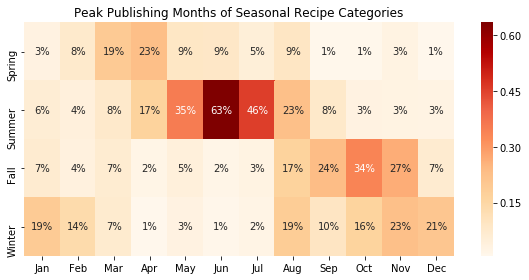

In [50]:
fig = plt.figure(figsize = (8,4))
plt.title("Peak Publishing Months of Seasonal Recipe Categories")
ax = sns.heatmap(seasonal_cat_by_month.T, annot=True, cmap='OrRd', fmt='.0%')
plt.tight_layout()
plt.show()

We can now see when seasonal recipes start to gain momentum/popularity. The heat map above displays the average number of recipes by seasonal category are published in specific months. We can see that Summer recipes are very popular, with the highest average of 62%. Though I'm sure that if we include categories such as 'Christmas' or 'Halloween' by season, we would see some higher averages in other seasons. Using this heat map, we can determine the best times for publishing seasonal recipes. They are as follows:

* Spring: March
* Summer: April or May
* Fall: August
* Winter: October

The summer and winter periods seem to last a bit longer than Fall and Spring. Spring looks especially short. It's good to know when these peak periods are though in the meal kit service line because Epicurious can prepare its supply chain in order to deliver meals in a timely fashion.

# Clustering

In [51]:
# initiate dataframes to put cluster information into
clusters_allrecipes_df = pd.DataFrame(df_cats['Title'])
clusters_meals_df = pd.DataFrame()

In [52]:
# fxn to calculate inertias for various ks
# return resulting inertias in a list
def calc_inertias(k_min, k_max, matrix):
    results = []
    ks = range(k_min, k_max)
    for k in ks:
        # Create a KMeans instance with k clusters
        kmeans = KMeans(n_clusters=k, random_state=10)    
        # Fit model to the matrix
        kmeans.fit(matrix)   
        # Append the inertia to the list of results
        results.append(kmeans.inertia_)
    
    return results    

In [53]:
# fxn to plot inertias
def plot_inertias(k_min, k_max, inertias):
    
    ks = range(k_min, k_max)
    
    plt.figure(figsize=(14,8))
    plt.plot(ks, inertias, '-o')
    plt.title('K vs Inertia')
    plt.xlabel('K (# of clusters)')
    plt.ylabel('Inertia')
    plt.xticks(ks)
    plt.show()

In [54]:
# compute kmeans for specified k and append to corresponding df
# return the clustercount
def compute_append_kmeans(k, df, matrix):
    header = 'cluster' + str(k)
    
    kmeans = KMeans(n_clusters=k, random_state=10)
    df[header] = kmeans.fit_predict(matrix)
    clustercount = pd.DataFrame(df[header].value_counts().sort_index())
    
    return clustercount

In [55]:
# plot bar graph of clusters and number of data points in each cluster
def cluster_hist(k, clustercount):
    header = 'cluster' + str(k)
    
    plt.figure(figsize=(8,6))
    sns.barplot(x=clustercount.index, y=clustercount.loc[:,header], palette = 'OrRd')
    plt.xticks(clustercount.index)
    plt.xlabel('Cluster')
    plt.ylabel('Count')
    plt.title('Number of Points in Each Cluster, k = %d' %(k))
    plt.show()


In [56]:
# compute silhouette scores for ks
def sil_scores(k_min, k_max, matrix):
    avg_s_scores = {}
    range_n_clusters = range(k_min,k_max)
    
     # test various sizes of k and save corresponding silhouette score
    for k in range_n_clusters:

        # Initialize the clusterer with k value and a random generator
        clusterer = KMeans(n_clusters=k, random_state=10)    
        cluster_labels = clusterer.fit_predict(matrix)   

        # compute silhouette score
        silhouette_avg = silhouette_score(matrix, cluster_labels)
        avg_s_scores[k] = silhouette_avg
        
    return avg_s_scores

In [57]:
# print silhouette scores from dictionary
def print_scores(scores_dict):
    for key, value in scores_dict.items():
        print('k =', key, ':', round(value,4))

In [58]:
# plot silhouette scores from dictionary
def plot_sil_scores(scores_dict, k_min, k_max):
    
    x, y = zip(*sorted(scores_dict.items()))
    
    plt.figure(figsize=(8,6))
    plt.plot(x, y, '-o')
    plt.xticks(range(k_min, k_max))
    plt.ylim(ymin = 0, ymax = float(y[0]) + .05)
    plt.xlabel('K')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Score, k=%d to k=%d' % (k_min, k_max-1))
    plt.grid(True, alpha=.2)
    plt.show()

### K-Means Clustering: Categories

#### All Categories

In [59]:
# transform binary category columns into a matrix
categories_matrix = np.matrix(df_cats.as_matrix())[:,8:]
categories_matrix.shape

(20052, 248)

In [60]:
# iterate through Ks from 1 to 12 and append inertias to list
results1 = calc_inertias(1, 13, categories_matrix)

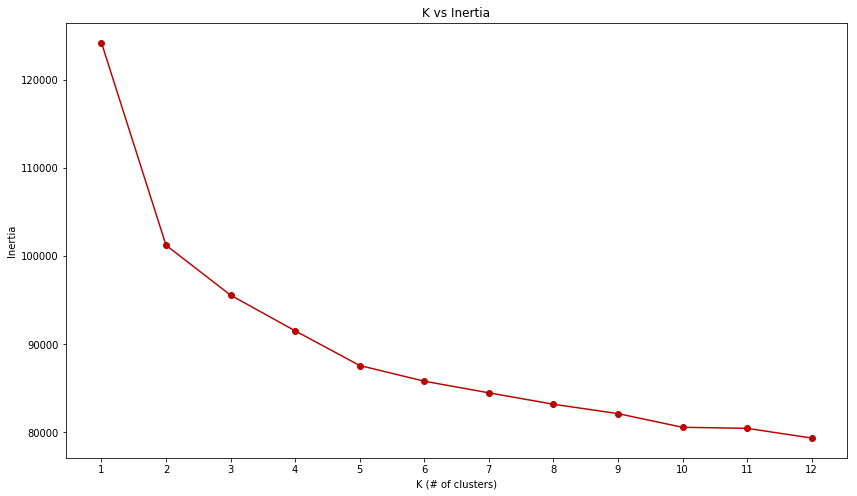

In [61]:
# Plot ks vs inertias
plot_inertias(1, 13, results1)

I would say that the elbow is either at k=5 or k=10. Let's see how many recipes fall into each cluster when k=5 and k=10

In [62]:
# cluster counts for k=5
cluster_count_5 = compute_append_kmeans(5, clusters_allrecipes_df, categories_matrix)
print(cluster_count_5)

   cluster5
0      3093
1      6456
2      2778
3      2630
4      5095


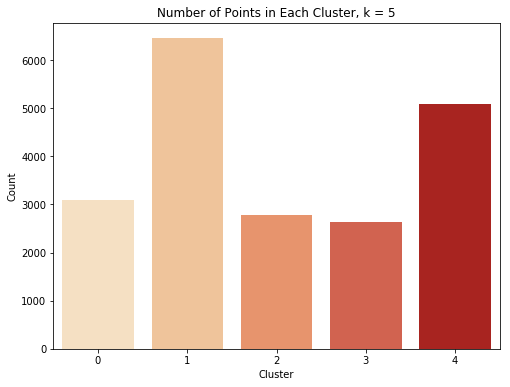

In [63]:
# plot histogram for k=5
cluster_hist(5, cluster_count_5)

In [64]:
# cluster counts for k=10
cluster_count_10 = compute_append_kmeans(10, clusters_allrecipes_df, categories_matrix)
print(cluster_count_10)

   cluster10
0       1412
1       4871
2       1483
3       2231
4       2462
5       1679
6       1542
7        801
8       1715
9       1856


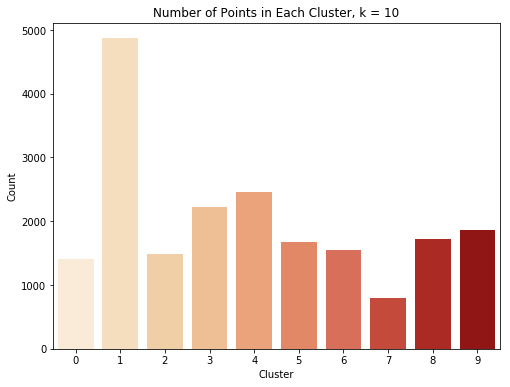

In [65]:
# plot histogram for k=10
cluster_hist(10, cluster_count_10)

I think that k=5 is more reasonable, but do we really want to limit how many customer segments we will have? We have a lot of categories, so it might be better to have 10 clusters. Let's check the silhouette scores for the various sizes of k.

In [66]:
# compute silhouette score for k=5
silhouette_avg_5 = silhouette_score(categories_matrix, clusters_allrecipes_df['cluster5'])

In [67]:
# compute silhouette score for k=10
silhouette_avg_10 = silhouette_score(categories_matrix, clusters_allrecipes_df['cluster10'])

In [68]:
print('Silhouette scores:')
print('k=5:', round(silhouette_avg_5,4))
print('k=10:', round(silhouette_avg_10,4))

Silhouette scores:
k=5: 0.0902
k=10: 0.0797


#### Categories where Recipe is Identified as a Meal

In [69]:
# construct dataframe that only contains recipes identified as meals

# create list of meal categories
meals = ['Breakfast', 'Lunch', 'Brunch', 'Dinner', 'Appetizer', 'Dessert']

# new column to identify if a recipe is for a meal category
df_cats['Meal Sum'] = df_cats.loc[:,'Breakfast'] + df_cats.loc[:,'Lunch'] + df_cats.loc[:,
                        'Brunch'] + df_cats.loc[:,'Dinner'] + df_cats.loc[:,'Appetizer'
                        ] + df_cats.loc[:,'Dessert']

# remove recipe row if it's not a meal
df_cats_meals = df_cats.loc[df_cats['Meal Sum'] > 0].loc[:, :'Wisconsin']
df_cats_meals.shape

/Users/isabelvanzijl/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


(8763, 256)

In [70]:
df_cats_meals.columns

Index(['Title', 'Rating', 'Rating Group', 'Date Time', 'Calories', 'Protein',
       'Fat', 'Sodium', '22-Minute Meals', '3-Ingredient Recipes',
       ...
       'Vegan', 'Vegetarian', 'Vermont', 'Virginia', 'Washington',
       'Washington, D.C.', 'Weelicious', 'Wheat/Gluten-Free', 'Winter',
       'Wisconsin'],
      dtype='object', length=256)

In [71]:
# let's also remove columns if there are no rows that have that category
df_cats_meals.drop([col for col, val in df_cats_meals.sum().iteritems() if val == 0], axis=1, inplace=True)
df_cats_meals.head()

,Title,Rating,Rating Group,Date Time,Calories,Protein,Fat,Sodium,22-Minute Meals,3-Ingredient Recipes,...,Vegan,Vegetarian,Vermont,Virginia,Washington,"Washington, D.C.",Weelicious,Wheat/Gluten-Free,Winter,Wisconsin
3,Mahi-Mahi in Tomato Olive Sauce,5.000,4-5,2009-03-27 04:00:00,NaN,NaN,NaN,NaN,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,Ham Persillade with Mustard Potato Salad and M...,3.750,3-4,2008-10-23 22:24:26,602.0,23.0,41.0,1696.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
11,Spicy Noodle Soup,4.375,4-5,2004-08-20 04:00:00,NaN,NaN,NaN,NaN,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12,Banana-Chocolate Chip Cake With Peanut Butter ...,4.375,4-5,2012-09-18 04:00:00,766.0,12.0,48.0,439.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16,Sweet Buttermilk Spoon Breads,1.875,1-2,2008-12-04 04:00:00,146.0,4.0,5.0,160.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [72]:
df_cats_meals.shape

(8763, 248)

In [73]:
# construct dataframe for saving meal time and cluster labels
clusters_meals_df = df_cats_meals[['Title','Breakfast', 'Lunch', 'Brunch', 'Dinner', 'Appetizer', 'Dessert']]

We've reduced our data set down to only 8,763 rows. Let's rerun the K-Means algorithm to see what results we get.

In [74]:
# transform binary category columns into a matrix
categories_matrix_meals = np.matrix(df_cats_meals.as_matrix())[:,8:]
categories_matrix_meals.shape

(8763, 240)

In [75]:
categories_matrix_meals

matrix([[0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
        [0.0, 0.0, 0.0, ..., 1.0, 0.0, 0.0],
        [0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
        ...,
        [0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
        [0.0, 0.0, 0.0, ..., 1.0, 0.0, 0.0],
        [0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0]], dtype=object)

In [76]:
# iterate through Ks from 1 to 12 and append inertias to list
results2 = calc_inertias(1, 13, categories_matrix_meals)

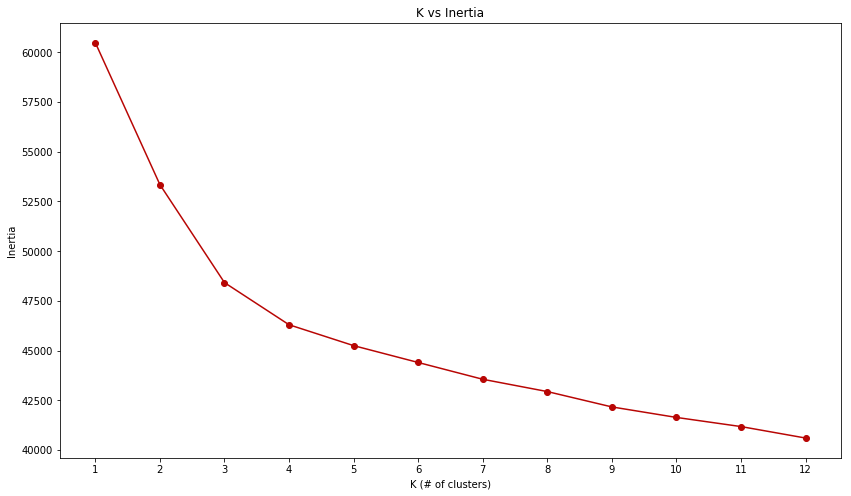

In [77]:
# Plot ks vs inertias
plot_inertias(1, 13, results2)

The elbow seems to appear around k=4, or maybe even k=3. Let's study the silhouette scores.

In [78]:
# compute silhouette scores
scores2 = sil_scores(2, 13, categories_matrix_meals)

# display silhouette scores
print_scores(scores2)

k = 2 : 0.119
k = 3 : 0.1272
k = 4 : 0.1215
k = 5 : 0.1022
k = 6 : 0.113
k = 7 : 0.0789
k = 8 : 0.0632
k = 9 : 0.0636
k = 10 : 0.0628
k = 11 : 0.0574
k = 12 : 0.0684


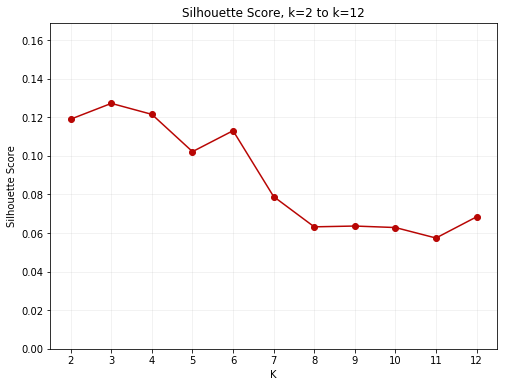

In [79]:
# plot silhouette scores
plot_sil_scores(scores2, 2, 13)

We've ended up with higher silhouette scores than before! And k=3 for our meal dataset results in the maximum silhouette score. But is this too few clusters for the segmentation? I think that k=6 is a more appropriate number of clusters. Let's check to see how the clusters are distributed for k=3 and k=6.

In [80]:
# cluster counts for k=3
cluster_count_3 = compute_append_kmeans(3, clusters_meals_df, categories_matrix_meals)
print(cluster_count_3)

   cluster3
0      3538
1      2209
2      3016


/Users/isabelvanzijl/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


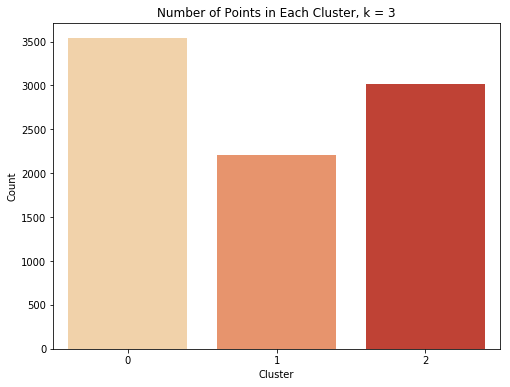

In [81]:
# plot histogram for k=3
cluster_hist(3, cluster_count_3)

In [82]:
# cluster counts for k=6
cluster_count_6 = compute_append_kmeans(6, clusters_meals_df, categories_matrix_meals)
print(cluster_count_6)

   cluster6
0      1142
1      1344
2      1299
3      2149
4      2096
5       733


/Users/isabelvanzijl/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


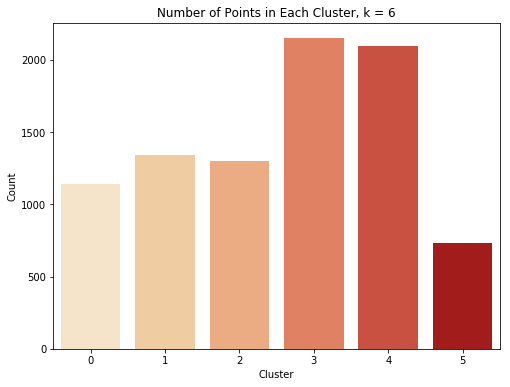

In [83]:
# plot histogram for k=6
cluster_hist(6, cluster_count_6)

My biggest concern for k=6 is that each cluster just contains one of our meal types (e.g. Breakfast or Dinner). If this ends up being the case, we may have to try reducing our data set to just be one type of meal.

In [84]:
# k=6, cluster=0
clusters_meals_df.loc[clusters_meals_df['cluster6'] == 0].head(10)[[
    'Title','Breakfast', 'Lunch', 'Brunch', 'Dinner', 'Appetizer', 'Dessert', 'cluster6']]

,Title,Breakfast,Lunch,Brunch,Dinner,Appetizer,Dessert,cluster6
34,Fontina Mac with Squash and Sage,0.0,1.0,0.0,1.0,0.0,0.0,0
47,Herbed Goat Cheese Spread with Mint,0.0,0.0,0.0,1.0,1.0,0.0,0
61,"Romaine, Grilled Avocado, and Smoky Corn Salad...",0.0,1.0,0.0,0.0,0.0,0.0,0
66,Scarborough Fair Tofu Burger,0.0,1.0,0.0,1.0,0.0,0.0,0
70,"Roasted Butternut Squash, Rosemary, and Garlic...",0.0,0.0,0.0,1.0,0.0,0.0,0
89,Ricotta Omelets,1.0,0.0,1.0,0.0,0.0,0.0,0
128,Spicy Sesame Noodles with Chopped Peanuts and ...,0.0,0.0,0.0,1.0,0.0,0.0,0
133,Radishes with Burrata,0.0,1.0,0.0,0.0,0.0,0.0,0
150,Jalapeño-Cheddar Frittata,0.0,0.0,1.0,0.0,1.0,0.0,0
151,Roasted Beets and Citrus with Feta,0.0,0.0,0.0,1.0,1.0,0.0,0


In [85]:
# k=6, cluster=1
clusters_meals_df.loc[clusters_meals_df['cluster6'] == 1].head(10)[[
    'Title','Breakfast', 'Lunch', 'Brunch', 'Dinner', 'Appetizer', 'Dessert', 'cluster6']]

,Title,Breakfast,Lunch,Brunch,Dinner,Appetizer,Dessert,cluster6
35,Aztec Chicken,0.0,0.0,0.0,1.0,0.0,0.0,1
43,Purple-Potato and Crab Gratin,0.0,1.0,0.0,0.0,0.0,0.0,1
53,Pancetta Roast Chicken with Walnut Stuffing,0.0,0.0,0.0,1.0,0.0,0.0,1
102,Parsnip and Apple Soup,0.0,0.0,0.0,0.0,1.0,0.0,1
103,Short Rib Pot Pie,0.0,0.0,0.0,1.0,0.0,0.0,1
146,Sage-Roasted Turkey with Caramelized Onions an...,0.0,0.0,0.0,1.0,0.0,0.0,1
147,Shrimp Cakes with Andouille Sausage,0.0,1.0,0.0,0.0,1.0,0.0,1
155,"Sauteed Veal with Shrimp, Mushroom, and Brandy...",0.0,0.0,0.0,1.0,0.0,0.0,1
170,Red Wine Brasato with Glazed Root Vegetables,0.0,0.0,0.0,1.0,0.0,0.0,1
178,Baked Beans with Slab Bacon and Breadcrumbs,0.0,0.0,0.0,1.0,0.0,0.0,1


In [86]:
# k=6, cluster=2
clusters_meals_df.loc[clusters_meals_df['cluster6'] == 2].head(10)[[
    'Title','Breakfast', 'Lunch', 'Brunch', 'Dinner', 'Appetizer', 'Dessert', 'cluster6']]

,Title,Breakfast,Lunch,Brunch,Dinner,Appetizer,Dessert,cluster6
3,Mahi-Mahi in Tomato Olive Sauce,0.0,0.0,0.0,1.0,0.0,0.0,2
9,Ham Persillade with Mustard Potato Salad and M...,0.0,1.0,0.0,0.0,0.0,0.0,2
19,"Tuna, Asparagus, and New Potato Salad with Chi...",0.0,1.0,0.0,0.0,0.0,0.0,2
30,Asian Steak Topped with Bell Pepper Stir-Fry,0.0,0.0,0.0,1.0,0.0,0.0,2
36,Pastry Twists with Spiced Sugar-Honey Glaze,0.0,0.0,0.0,0.0,0.0,1.0,2
44,"Grilled Beef, Jícama, and Apple Salad",0.0,0.0,0.0,1.0,0.0,0.0,2
50,Mexican Chile and Mushroom Soup,0.0,1.0,0.0,0.0,0.0,0.0,2
52,Braised Chicken With Artichokes and Olives,0.0,0.0,0.0,1.0,0.0,0.0,2
55,Collard-and-Prosciutto Chicken Roulades Over W...,0.0,0.0,0.0,1.0,0.0,0.0,2
80,"Braised Chicken and Rice with Orange, Saffron,...",0.0,0.0,0.0,1.0,0.0,0.0,2


In [87]:
# k=6, cluster=3
clusters_meals_df.loc[clusters_meals_df['cluster6'] == 3].head(10)[[
    'Title','Breakfast', 'Lunch', 'Brunch', 'Dinner', 'Appetizer', 'Dessert', 'cluster6']]

,Title,Breakfast,Lunch,Brunch,Dinner,Appetizer,Dessert,cluster6
11,Spicy Noodle Soup,1.0,0.0,0.0,0.0,0.0,0.0,3
22,Fish Fillets in Parchment with Asparagus and O...,0.0,0.0,0.0,1.0,0.0,0.0,3
23,Pancetta and Taleggio Lasagna with Treviso,0.0,0.0,0.0,1.0,0.0,0.0,3
51,Peanut Butter-Banana Muffins,1.0,0.0,1.0,0.0,0.0,0.0,3
54,1977 Coconut Angel Food Cake,0.0,0.0,0.0,0.0,0.0,1.0,3
76,South American-Style Jícama and Orange Salad,0.0,0.0,0.0,0.0,1.0,0.0,3
78,Maple Pumpkin Pots de Crème,0.0,0.0,0.0,0.0,0.0,1.0,3
86,Bacon Crackers,0.0,0.0,0.0,0.0,1.0,0.0,3
87,Roast Chicken With Sorghum and Squash,0.0,0.0,0.0,1.0,0.0,0.0,3
97,Roast Beef Salad with Cabbage and Horseradish,0.0,1.0,0.0,0.0,0.0,0.0,3


In [88]:
# k=6, cluster=4
clusters_meals_df.loc[clusters_meals_df['cluster6'] == 4].head(10)[[
    'Title','Breakfast', 'Lunch', 'Brunch', 'Dinner', 'Appetizer', 'Dessert', 'cluster6']]

,Title,Breakfast,Lunch,Brunch,Dinner,Appetizer,Dessert,cluster6
12,Banana-Chocolate Chip Cake With Peanut Butter ...,0.0,0.0,0.0,0.0,0.0,1.0,4
16,Sweet Buttermilk Spoon Breads,1.0,0.0,1.0,0.0,0.0,1.0,4
29,Apricot-Cherry Shortcakes,0.0,0.0,0.0,0.0,0.0,1.0,4
40,Coconut-Key Lime Sheet Cake,0.0,0.0,0.0,0.0,0.0,1.0,4
57,Pumpkin Muffins,1.0,0.0,1.0,0.0,0.0,0.0,4
64,Mixed Berry Pavlovas,0.0,0.0,0.0,0.0,0.0,1.0,4
65,Orange-Almond Cake with Chocolate Icing,0.0,0.0,0.0,0.0,0.0,1.0,4
68,White Chocolate Tartlets with Strawberries and...,0.0,0.0,0.0,0.0,0.0,1.0,4
72,Pear-Hazelnut Cheesecakes with Pear-Raspberry ...,0.0,0.0,0.0,0.0,0.0,1.0,4
75,Banana Layer Cake with Cream Cheese Frosting,0.0,0.0,0.0,0.0,0.0,1.0,4


In [89]:
# k=6, cluster=5
clusters_meals_df.loc[clusters_meals_df['cluster6'] == 5].head(10)[[
    'Title','Breakfast', 'Lunch', 'Brunch', 'Dinner', 'Appetizer', 'Dessert', 'cluster6']]

,Title,Breakfast,Lunch,Brunch,Dinner,Appetizer,Dessert,cluster6
26,Cucumber-Basil Egg Salad,0.0,1.0,0.0,1.0,0.0,0.0,5
49,Citrus Salad with Mint Sugar,1.0,0.0,1.0,0.0,0.0,0.0,5
114,"Cranberry, Quince, and Pearl Onion Compote",1.0,0.0,0.0,0.0,0.0,0.0,5
148,Creamy Tofu Salad,0.0,1.0,0.0,0.0,0.0,0.0,5
172,Egg Salad with Lemon and Fennel,0.0,0.0,0.0,1.0,0.0,0.0,5
196,Lemon-Parsley Linguine,0.0,0.0,0.0,1.0,0.0,0.0,5
229,Blackberry-Raspberry Sauce,0.0,0.0,0.0,0.0,0.0,1.0,5
242,"Frisée, Radicchio, and Asian Pear Salad with H...",0.0,1.0,0.0,0.0,0.0,0.0,5
271,Breakfast Bowl With Quinoa and Berries,1.0,0.0,0.0,0.0,0.0,0.0,5
295,Florida Ambrosia Salad,0.0,0.0,0.0,0.0,0.0,1.0,5


Let's try to visualize the six clusters

In [90]:
# initiate PCA
pca = PCA(n_components = 2)

# build dataframe
pca_df = pd.DataFrame(np.matrix(pca.fit_transform(categories_matrix_meals)), columns=['x','y'])
clusters_meals_df['x6'], clusters_meals_df['y6'] = pca_df.loc[:,'x'], pca_df.loc[:,'y']

clusters_meals_df.head()

/Users/isabelvanzijl/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,Title,Breakfast,Lunch,Brunch,Dinner,Appetizer,Dessert,cluster3,cluster6,x6,y6
3,Mahi-Mahi in Tomato Olive Sauce,0.0,0.0,0.0,1.0,0.0,0.0,0,2,-0.454989,-1.117746
9,Ham Persillade with Mustard Potato Salad and M...,0.0,1.0,0.0,0.0,0.0,0.0,0,2,-0.815102,-0.942817
11,Spicy Noodle Soup,1.0,0.0,0.0,0.0,0.0,0.0,1,3,-0.730748,0.690416
12,Banana-Chocolate Chip Cake With Peanut Butter ...,0.0,0.0,0.0,0.0,0.0,1.0,2,4,0.394607,0.927470
16,Sweet Buttermilk Spoon Breads,1.0,0.0,1.0,0.0,0.0,1.0,2,4,0.156614,1.006022


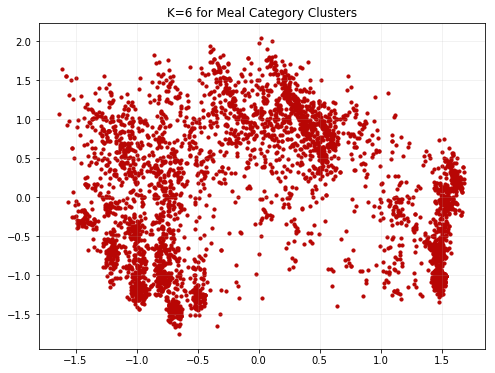

In [91]:
# plot clusters without cluster colors
fig = plt.figure(figsize = (8,6))
plt.scatter(x = clusters_meals_df['x6'], y = clusters_meals_df['y6'], s = 10)
plt.title('K=6 for Meal Category Clusters')
plt.grid(True, alpha=.2)

In [92]:
color_map_6 = plt.get_cmap('OrRd_r')

colors6 = color_map_6(np.linspace(0, .9, 6))
print(colors6)

[[0.49803922 0.         0.         1.        ]
 [0.76452134 0.08341407 0.05387159 1.        ]
 [0.92655133 0.37244137 0.26406767 1.        ]
 [0.9895271  0.61236448 0.40456747 1.        ]
 [0.99215686 0.80907343 0.59641676 1.        ]
 [0.99692426 0.92249135 0.81476355 1.        ]]


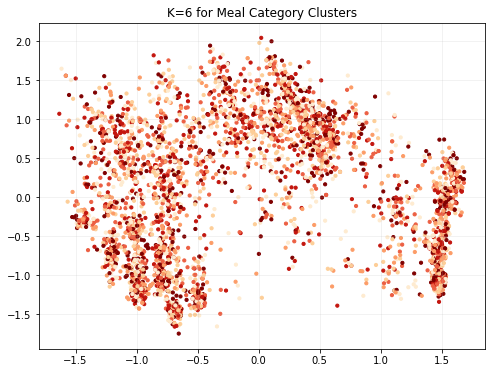

In [93]:
# plot clusters with cluster colors
fig = plt.figure(figsize = (8,6))
plt.scatter(x = clusters_meals_df['x6'], y = clusters_meals_df['y6'], s = 10, 
            c = colors6)
plt.title('K=6 for Meal Category Clusters')
plt.grid(True, alpha=.2)

We are definitely not getting any clear clusters. Ignoring the colors in the above plot, it would seem that there would be some relateively clear clusters. I could definitely see how k=3 would have provided us with the best silhouette score. But once we color code each point by cluster, it is utter chaos. There are no clearly colored clusters and all the colored points are scattered everywhere.

We will have to try reducing some fields to see if we get better results. But first, since k=3 provided us with the highest silhouette score, let's see if it can provide us with a clear visualization of recipe clusters.

In [94]:
# build dataframe
pca_df3 = pd.DataFrame(np.matrix(pca.fit_transform(categories_matrix_meals)), columns=['x','y'])
clusters_meals_df['x3'], clusters_meals_df['y3'] = pca_df3.loc[:,'x'], pca_df3.loc[:,'y']

clusters_meals_df.head()

/Users/isabelvanzijl/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Title,Breakfast,Lunch,Brunch,Dinner,Appetizer,Dessert,cluster3,cluster6,x6,y6,x3,y3
3,Mahi-Mahi in Tomato Olive Sauce,0.0,0.0,0.0,1.0,0.0,0.0,0,2,-0.454989,-1.117746,-0.454989,-1.117746
9,Ham Persillade with Mustard Potato Salad and M...,0.0,1.0,0.0,0.0,0.0,0.0,0,2,-0.815102,-0.942817,-0.815101,-0.942819
11,Spicy Noodle Soup,1.0,0.0,0.0,0.0,0.0,0.0,1,3,-0.730748,0.690416,-0.730748,0.690417
12,Banana-Chocolate Chip Cake With Peanut Butter ...,0.0,0.0,0.0,0.0,0.0,1.0,2,4,0.394607,0.927470,0.394608,0.927468
16,Sweet Buttermilk Spoon Breads,1.0,0.0,1.0,0.0,0.0,1.0,2,4,0.156614,1.006022,0.156614,1.006023


In [95]:
# assign colors for clusters
color_map_3 = plt.get_cmap('OrRd_r')

colors3 = color_map_3(np.linspace(0, .5, 3))
print(colors3)

[[0.49803922 0.         0.         1.        ]
 [0.84387543 0.18986544 0.12282968 1.        ]
 [0.98829681 0.55577086 0.35166474 1.        ]]


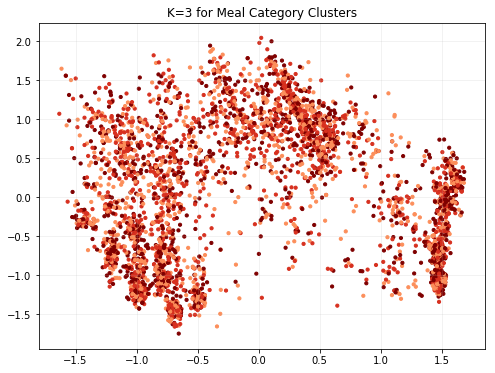

In [96]:
# plot clusters with cluster colors
fig = plt.figure(figsize = (8,6))
plt.scatter(x = clusters_meals_df['x3'], y = clusters_meals_df['y3'], s = 10, 
            c = colors3)
plt.title('K=3 for Meal Category Clusters')
plt.grid(True, alpha=.2)

We're still not getting any clusters that stand out. It's possible that our data is too highly dimensional.

#### Categories where Recipe is Identified as a Meal and has a Rating of 5

We clearly need to have a better defined data set since there are no clear clusters above. Let's try clustering recipes that have been identified as a type of meal and have a rating of 5. We will want to use our most highly rated recipes anyway, so eliminating lower rated recipes now will hopefully just help our clustering algorithm.

In [97]:
# remove rows with rating less than 5
df_cats_meals_rating = df_cats_meals.loc[df_cats_meals['Rating'] == 5].loc[:, :'Wisconsin']
df_cats_meals_rating.shape

(1352, 248)

In [98]:
# remove columns if there are no rows that have that category
df_cats_meals_rating.drop([col for col, val in df_cats_meals_rating.sum().iteritems() if 
                           val == 0], axis=1, inplace=True)
df_cats_meals_rating.shape

(1352, 198)

In [99]:
clusters_meals_rating_df = df_cats_meals[['Title','Breakfast', 'Lunch', 'Brunch', 
                                          'Dinner', 'Appetizer', 'Dessert']]

In [100]:
# transform binary category columns into a matrix
categories_matrix_meals_rating = np.matrix(df_cats_meals_rating.as_matrix())[:,8:]
categories_matrix_meals_rating.shape

(1352, 190)

In [101]:
categories_matrix_meals_rating

matrix([[0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
        [0.0, 0.0, 0.0, ..., 0.0, 1.0, 0.0],
        [0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
        ...,
        [0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
        [0.0, 0.0, 0.0, ..., 0.0, 1.0, 0.0],
        [0.0, 1.0, 0.0, ..., 0.0, 0.0, 0.0]], dtype=object)

In [102]:
# iterate through Ks from 1 to 12 and append inertias to list
results3 = calc_inertias(1, 13, categories_matrix_meals_rating)

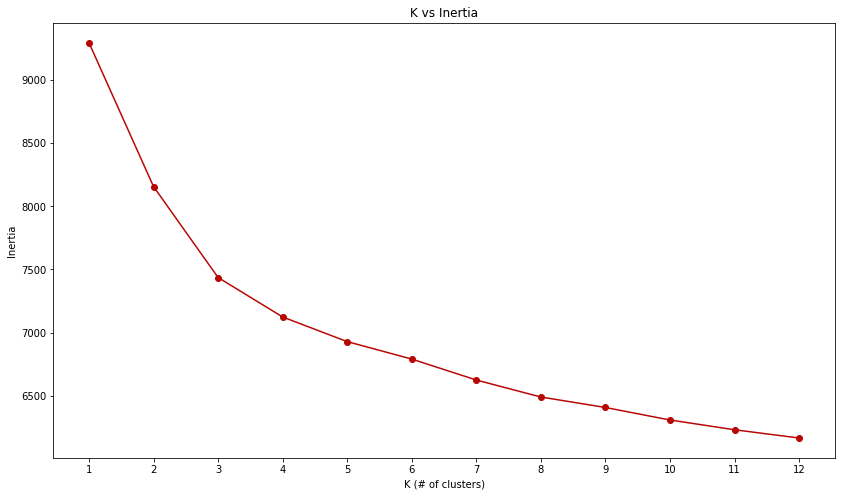

In [103]:
# Plot ks vs inertias
plot_inertias(1, 13, results3)

The elbow here seems to appear around k=4

In [104]:
# compute silhouette scores
scores3 = sil_scores(2, 13, categories_matrix_meals_rating)

# display silhouette scores
print_scores(scores3)

k = 2 : 0.1225
k = 3 : 0.1287
k = 4 : 0.1207
k = 5 : 0.0997
k = 6 : 0.0771
k = 7 : 0.0898
k = 8 : 0.0728
k = 9 : 0.0752
k = 10 : 0.0711
k = 11 : 0.0746
k = 12 : 0.0715


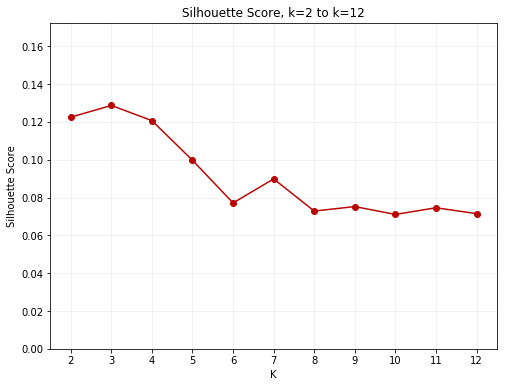

In [105]:
# plot silhouette scores
plot_sil_scores(scores3, 2, 13)

In our other silhouette score plot, we saw a spike at k=6. Here we see a spike at k=7 but the silhouette score is still lower that what we originally had.

Let's compare the silhouette scores from before:

In [106]:
# print all score differences from dictionaries
for key, value1 in scores2.items():
    value2 = scores3[key]
    print('k =', key, ': [Meals] - [Meals and Rating of 5]: ', round(value1,4), 
          '-', round(value2,4),'=', round(value1-value2,4))
    
max1key = 0
max1value = 0
max2key = 0
max2value = 0

for key, value in scores2.items():
    if value > max1value:
        max1key = key
        max1value = value
    
for key, value in scores3.items():
    if value > max2value:
        max2key = key
        max2value = value

print()
print('Meal categories: highest k = %s with silhouette score of %.4f' % (max1key, max1value))
print('Meal categories with a rating of 5: highest k = %s with silhouette score of %.4f' % (max2key, max2value))

k = 2 : [Meals] - [Meals and Rating of 5]:  0.119 - 0.1225 = -0.0035
k = 3 : [Meals] - [Meals and Rating of 5]:  0.1272 - 0.1287 = -0.0015
k = 4 : [Meals] - [Meals and Rating of 5]:  0.1215 - 0.1207 = 0.0008
k = 5 : [Meals] - [Meals and Rating of 5]:  0.1022 - 0.0997 = 0.0025
k = 6 : [Meals] - [Meals and Rating of 5]:  0.113 - 0.0771 = 0.0359
k = 7 : [Meals] - [Meals and Rating of 5]:  0.0789 - 0.0898 = -0.011
k = 8 : [Meals] - [Meals and Rating of 5]:  0.0632 - 0.0728 = -0.0096
k = 9 : [Meals] - [Meals and Rating of 5]:  0.0636 - 0.0752 = -0.0116
k = 10 : [Meals] - [Meals and Rating of 5]:  0.0628 - 0.0711 = -0.0082
k = 11 : [Meals] - [Meals and Rating of 5]:  0.0574 - 0.0746 = -0.0172
k = 12 : [Meals] - [Meals and Rating of 5]:  0.0684 - 0.0715 = -0.0031

Meal categories: highest k = 3 with silhouette score of 0.1272
Meal categories with a rating of 5: highest k = 3 with silhouette score of 0.1287


For the max k of 3, the meal categories with ratings higher than 4 results in a slightly higher silhouette score. But for k=6, our previous result without limiting recipes by rating gave us a higher silhouette score. Limiting our dataset to only recipes with a user rating of 5 has overall not improved our results, so we will stick with the original meal matrix.

#### Categories and Ingredients where Recipe is Identified as a Meal

Considering the above result, I think that these clusters could be a little more clear cut. Let's see what happens when we specify meal categories on the dataframe that contains both categories and ingredients.

In [107]:
df_full['Meal Sum'] = df_full.loc[:,'Breakfast'] + df_full.loc[:,'Lunch'] + df_full.loc[:,
                        'Brunch'] + df_full.loc[:,'Dinner'] + df_full.loc[:,'Appetizer'
                        ] + df_full.loc[:,'Dessert']

df_full_meals = df_full.loc[df_full['Meal Sum'] > 0].loc[:, '22-Minute Meals':'Zucchini']

df_full_meals.shape

/Users/isabelvanzijl/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


(8763, 587)

In [108]:
# let's also remove columns if there are no rows that have that category/ingredient
df_full_meals.drop([col for col, val in df_full_meals.sum().iteritems() if val == 0], axis=1, inplace=True)
df_full_meals.shape

(8763, 576)

In [109]:
# transform binary category columns into a matrix
full_matrix_meals = np.matrix(df_full_meals.as_matrix())[:,8:]
full_matrix_meals.shape

(8763, 568)

In [110]:
full_matrix_meals

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

In [111]:
# check to make sure all binary variables
for i, row in df_full_meals.iterrows():
    for j in row.index:
        if row[j] > 1:
            print(i, j, row[j])

In [112]:
# iterate through Ks from 1 to 12 and append inertias to list
results4 = calc_inertias(1, 13, full_matrix_meals)

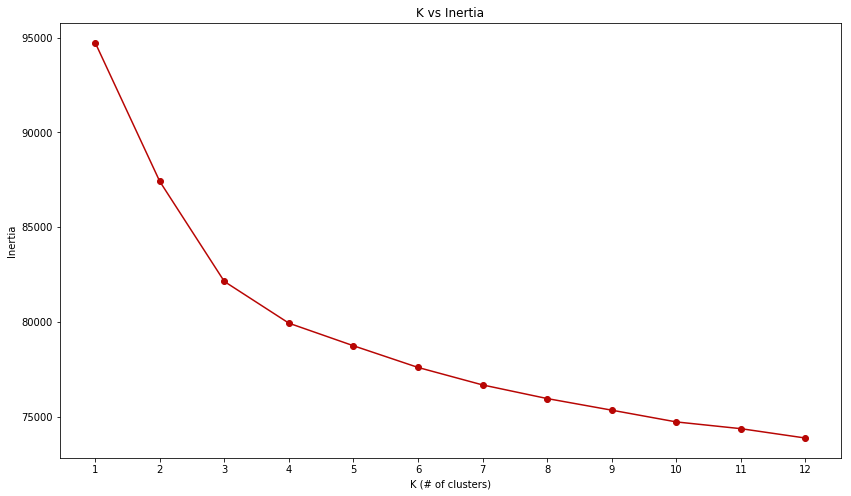

In [113]:
# Plot ks vs inertias
plot_inertias(1, 13, results4)

The elbow again seems to be at k=4, and no other number of clusters stands out to me.

In [114]:
# compute silhouette scores
scores4 = sil_scores(2, 13, full_matrix_meals)

# display silhouette scores
print_scores(scores4)

k = 2 : 0.0776
k = 3 : 0.0799
k = 4 : 0.0772
k = 5 : 0.0594
k = 6 : 0.0446
k = 7 : 0.0438
k = 8 : 0.0382
k = 9 : 0.0383
k = 10 : 0.0394
k = 11 : 0.0285
k = 12 : 0.0343


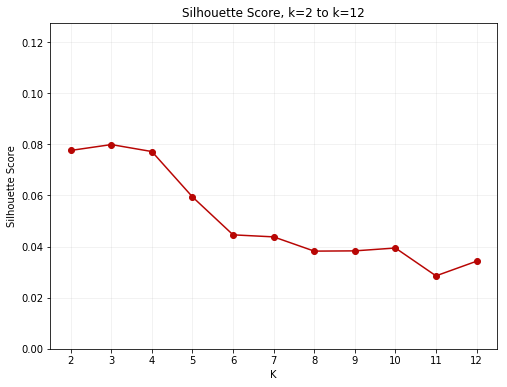

In [115]:
# plot silhouette scores
plot_sil_scores(scores4, 2, 13)

Adding the ingredient columns to our dataset worsened our results. So far k=3 for our meal specified categories givees us the highest silhouette score. But perhaps we can get better results from a different algorithm. K-means is meant to provide us with a low number of clusters usually, so maybe we'll get better results from an algorithm that's meant to provide us with more clusters. Considering that we have so much data, I think that this could work out well. I also think that we should keep only including rows that have at least one meal tag, since it has so far provided us with the best results in the K-Means algorithm.

### K-Means Clustering: NLP of Recipe Titles

We haven't been able to successfully identify clusters from category or ingredient tags, so let's see if studying the similarities between reicpe titles yields any results.

#### Implement word2vec

In [116]:
# fxn to convert meals df to list of words
def sentence_to_wordlist(recipe, remove_stopwords=False):
    
    # remove non-letters
    recipe_text = re.sub(r'[^\w\s]','', recipe)
    recipe_text = re.sub(r'-',' ', recipe)
    
    # convert words to lower case and split them
    words = recipe_text.lower().split()
    
    # return a list of words
    return(words)

In [117]:
# fxn to split text into parsed sentences
def rec_to_sentence(recipe, tokenizer, remove_stopwords=False ):
    try:
        # use the NLTK tokenizer to split the text into sentences
        raw_sentences = tokenizer.tokenize(recipe.strip())
        
        # 2loop over each sentence
        sentences = []
        for raw_sentence in raw_sentences:
            # If a sentence is empty, skip it
            if len(raw_sentence) > 0:
                # call sentence_to_wordlist to get a list of words
                sentences.append(sentence_to_wordlist(raw_sentence))
        # return the list of sentences (each sentence is a list of words, so this returns a list of lists)
        len(sentences)
        return sentences
    except:
        print('nope')

In [118]:
# apply fxns to recipe names
recipes = clusters_meals_df['Title'].tolist()
titles = []

for i in range(0,len(recipes)):
    try:
        # apply fxn
        titles += rec_to_sentence(recipes[i], tokenizer)
    except:
        print('no!')

In [119]:
# remove basic words
for i in titles:
    for j in i:
        if j in ('in','with','and', 'of'):
            i.remove(j)

In [120]:
print("There are " + str(len(titles)) + " recipes that we are studying.")

There are 8766 recipes that we are studying.


In [121]:
# check one of the sentences
titles[200]

['bittersweet', 'chocolate', 'citrus', 'tart', 'jasmine', 'whipped', 'cream']

In [122]:
# initialize the model
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s',\
    level=logging.INFO)

num_features = 100    # Word vector dimensionality                      
min_word_count = 10   # Minimum word count                        
num_workers = 4       # Number of threads to run in parallel
context = 6           # Context window size                                                                                    
downsampling = 1e-3   # Downsample setting for frequent words
batch = 5000          # Target size for batches

model = word2vec.Word2Vec(titles, workers=num_workers, \
            size=num_features, min_count = min_word_count, \
            window = context, sample = downsampling, batch_words = batch)

2018-02-24 23:13:35,221 : INFO : collecting all words and their counts
2018-02-24 23:13:35,225 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2018-02-24 23:13:35,249 : INFO : collected 3658 word types from a corpus of 40018 raw words and 8766 sentences
2018-02-24 23:13:35,251 : INFO : Loading a fresh vocabulary
2018-02-24 23:13:35,257 : INFO : min_count=10 retains 709 unique words (19% of original 3658, drops 2949)
2018-02-24 23:13:35,259 : INFO : min_count=10 leaves 33441 word corpus (83% of original 40018, drops 6577)
2018-02-24 23:13:35,266 : INFO : deleting the raw counts dictionary of 3658 items
2018-02-24 23:13:35,269 : INFO : sample=0.001 downsamples 89 most-common words
2018-02-24 23:13:35,271 : INFO : downsampling leaves estimated 27091 word corpus (81.0% of prior 33441)
2018-02-24 23:13:35,277 : INFO : estimated required memory for 709 words and 100 dimensions: 921700 bytes
2018-02-24 23:13:35,279 : INFO : resetting layer weights
2018-02-24 23:13:3

In [123]:
model.init_sims(replace=True)

2018-02-24 23:13:35,601 : INFO : precomputing L2-norms of word weight vectors


In [124]:
words = list(model.wv.vocab.keys())

# look at first 25 words
words[:25]

['tomato',
 'olive',
 'sauce',
 'ham',
 'mustard',
 'potato',
 'salad',
 'mashed',
 'peas',
 'spicy',
 'noodle',
 'soup',
 'banana',
 'chocolate',
 'chip',
 'cake',
 'peanut',
 'butter',
 'frosting',
 'sweet',
 'buttermilk',
 'asparagus,',
 'new',
 'chive',
 'vinaigrette']

In [125]:
# let's see what the semantic vector for 'salad' looks like
model.wv.__getitem__('salad')

array([ 0.07727812,  0.07567571, -0.10642266,  0.10963778,  0.03213954,
       -0.12802076, -0.15618032, -0.02969754,  0.11198721, -0.00945838,
       -0.1297045 ,  0.07240681, -0.00847884, -0.0621195 ,  0.13196267,
        0.23261745,  0.1372655 ,  0.04079379,  0.04051827,  0.07458595,
        0.00826322, -0.06480214, -0.02060024,  0.06663391, -0.04720899,
       -0.05276285, -0.10690932, -0.08923567, -0.20451877, -0.0208411 ,
       -0.17098713,  0.06840993, -0.08685921, -0.00108381,  0.11796608,
        0.11723706,  0.11499453, -0.03925329,  0.12482067, -0.0633515 ,
        0.09077454,  0.00951232, -0.09681981,  0.11253673, -0.16326022,
        0.01227511, -0.08826012,  0.00866634, -0.069114  , -0.02057032,
       -0.0065064 , -0.20000528, -0.16245778,  0.03151622,  0.07660192,
       -0.01850676,  0.11800601, -0.11988365,  0.0383274 ,  0.06902118,
       -0.04251174,  0.08565118, -0.01435023, -0.13875796, -0.05183623,
       -0.17082171,  0.10794076, -0.1644258 , -0.12176024, -0.11

In [126]:
# identify common phrases
bigramer = gensim.models.Phrases(titles)

2018-02-24 23:13:35,663 : INFO : collecting all words and their counts
2018-02-24 23:13:35,667 : INFO : PROGRESS: at sentence #0, processed 0 words and 0 word types
2018-02-24 23:13:35,809 : INFO : collected 22862 word types from a corpus of 40018 words (unigram + bigrams) and 8766 sentences
2018-02-24 23:13:35,811 : INFO : using 22862 counts as vocab in Phrases<0 vocab, min_count=5, threshold=10.0, max_vocab_size=40000000>


In [127]:
model = Word2Vec(bigramer[titles], workers=num_workers, \
            size=num_features, min_count = min_word_count, \
            window = context, sample = downsampling, \
            batch_words = batch)

/Users/isabelvanzijl/anaconda3/lib/python3.6/site-packages/gensim/models/phrases.py:486: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")
2018-02-24 23:13:35,828 : INFO : collecting all words and their counts
2018-02-24 23:13:35,829 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2018-02-24 23:13:36,265 : INFO : collected 3846 word types from a corpus of 36433 raw words and 8766 sentences
2018-02-24 23:13:36,267 : INFO : Loading a fresh vocabulary
2018-02-24 23:13:36,276 : INFO : min_count=10 retains 739 unique words (19% of original 3846, drops 3107)
2018-02-24 23:13:36,278 : INFO : min_count=10 leaves 29007 word corpus (79% of original 36433, drops 7426)
2018-02-24 23:13:36,284 : INFO : deleting the raw counts dictionary of 3846 items
2018-02-24 23:13:36,287 : INFO : sample=0.001 downsamples 79 most-common words
2018-02-24 23:13:3

In [128]:
# remove basic words    
model.wv.vocab = { k : v for k,v in model.wv.vocab.items() if v not in ('with','and','in', 'of')}

In [129]:
phrases = list(model.wv.vocab.keys())

# look at top 25 phrases
phrases[:25]

['tomato',
 'olive',
 'sauce',
 'ham',
 'mustard',
 'potato',
 'salad',
 'peas',
 'spicy',
 'noodle_soup',
 'banana',
 'chocolate_chip',
 'cake',
 'peanut_butter',
 'frosting',
 'sweet',
 'buttermilk',
 'asparagus,',
 'new',
 'chive',
 'vinaigrette',
 'fried',
 'capers',
 'asparagus',
 'orange']

In [130]:
# let's look at the vector array for goat cheese
model.wv.__getitem__('goat_cheese')

array([ 0.00082087,  0.00340174,  0.0009749 , -0.0002563 , -0.00415514,
        0.00149315,  0.00079   ,  0.00085179, -0.00198428,  0.00258451,
        0.00258571,  0.00428634,  0.00419468,  0.0045189 ,  0.00216172,
        0.0028288 , -0.00277959, -0.00225766,  0.00273034,  0.00473204,
        0.00374812, -0.00213454,  0.00277134,  0.00267713,  0.00241712,
        0.00401431,  0.00207517,  0.00168765,  0.00131116,  0.00056651,
        0.00171881, -0.00276422, -0.00149163,  0.00322711,  0.00252963,
       -0.00221617, -0.00219098, -0.00257673, -0.00020301,  0.00205985,
       -0.00246773, -0.00108439, -0.00468189, -0.00415839, -0.00039696,
       -0.00174272,  0.00425842,  0.00012914,  0.0048969 , -0.00201598,
        0.00301459,  0.00126842,  0.00314878, -0.00362907,  0.004785  ,
       -0.00136408,  0.00444024,  0.00430803,  0.00102262, -0.00144449,
        0.00479268,  0.00334593,  0.0003062 ,  0.00456334,  0.00088411,
       -0.00305582, -0.00283872,  0.00111513, -0.00338667,  0.00

In [131]:
# let's look at some similarities to goat_cheese, top 15 most similar
model.wv.most_similar('goat_cheese',  topn=15)

2018-02-24 23:13:36,446 : INFO : precomputing L2-norms of word weight vectors


[('lime', 0.3073630928993225),
 ('chestnut', 0.2899627387523651),
 ('glazed', 0.2753205895423889),
 ('parfaits', 0.2721404731273651),
 ('dried_fruit', 0.26097869873046875),
 ('style', 0.23462072014808655),
 ('kale', 0.2297363132238388),
 ('tomato', 0.22847969830036163),
 ('crunchy', 0.22842822968959808),
 ('lemon_curd', 0.2232307344675064),
 ('wilted', 0.22318151593208313),
 ('couscous', 0.22109243273735046),
 ('italian_sausage', 0.21844694018363953),
 ('grapefruit,', 0.21541538834571838),
 ('key_lime', 0.20800882577896118)]

In [132]:
phrases_df = pd.DataFrame()
listoflists = []

# construct dataframe of vectors
for i in phrases:
    vectorlist = np.ndarray.tolist(model.wv.__getitem__(i))
    listoflists.append(vectorlist)
    
phrases_df = pd.DataFrame(listoflists, index=phrases)
phrases_df.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
tomato,-0.004532,0.004897,-0.000162,-0.004055,-0.004771,-0.002518,0.002746,-0.004058,0.000591,-0.004147,...,0.000433,0.002837,-0.002886,0.000163,-0.004972,-0.004061,-0.003810,0.003428,0.000484,-0.001517
olive,0.003556,-0.003152,-0.001975,-0.000812,0.003142,0.000371,-0.001191,0.002957,0.003392,-0.003006,...,0.003907,-0.000892,0.002975,0.003924,0.002422,-0.003063,-0.002504,-0.003312,0.002772,-0.001182
sauce,0.004277,-0.000415,0.003381,0.002286,-0.002431,-0.002524,-0.001086,0.004043,0.000271,-0.001092,...,-0.003044,-0.003536,0.003891,0.001444,0.004150,-0.002284,-0.003985,0.004134,-0.000665,0.002205
ham,-0.003743,-0.003663,-0.001256,0.003956,0.003151,-0.000680,0.004452,0.002143,-0.004002,0.003577,...,-0.002033,-0.004151,-0.001612,0.000948,-0.004032,0.004569,0.002649,-0.003532,0.000371,-0.002000
mustard,-0.004830,0.001612,-0.002949,-0.003589,0.002480,0.001830,-0.004679,-0.003077,0.004708,0.002425,...,-0.002569,0.001789,-0.000011,0.003810,-0.002990,-0.001576,0.001016,0.000537,0.001367,0.000276


In [133]:
phrases_df.shape

(739, 100)

In [134]:
# initiate dataframe to average the vectors for phrases in recipe titles
recipe_titles_df = pd.DataFrame(columns=phrases_df.columns)
recipe_titles_df.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99


In [135]:
dict_dimensions = dict.fromkeys(list(range(len(recipe_titles_df.columns))))

for i, title in zip(range(len(recipes)), recipes):   
    
    dict_dimensions = {k: 0 for k in dict_dimensions.keys()}
    #print(dict_dimensions)
    
    len_title = len(titles[i])
    #print(len_title)
    
    for word in titles[i]:
        if word in phrases:
            v = model.wv.__getitem__(word).tolist()
            #print(word, v)
            
            for key, val in dict_dimensions.items():
                dict_dimensions[key] += v[key]
                #print(val)
        else:
            len_title -= 1
            
    dict_dim_avg = {k: val / float(len_title) for k,val in dict_dimensions.items() if len_title > 0}
    
    for k, avg in dict_dim_avg.items():
        if avg != 0:
            recipe_titles_df.at[title,k] = avg

In [136]:
# fill any null values with zero
recipe_titles_df = recipe_titles_df.fillna(0)
recipe_titles_df.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
Mahi-Mahi in Tomato Olive Sauce,0.001101,0.000443,0.000415,-0.000861,-0.001353,-0.001557,0.000156,0.000981,0.001418,-0.002749,...,0.000432,-0.000530,0.001327,0.001844,0.000533,-0.003136,-0.003433,0.001417,0.000864,-0.000165
Ham Persillade with Mustard Potato Salad and Mashed Peas,-0.001680,-0.002126,-0.000716,0.000087,0.000578,0.000444,-0.001108,0.000218,0.002626,0.002343,...,-0.001801,-0.000459,0.001623,-0.001037,-0.000689,0.000689,0.000047,-0.001650,0.001369,-0.002392
Spicy Noodle Soup,0.001820,0.003951,-0.000836,0.002033,-0.003160,-0.004449,0.001450,-0.001693,-0.001349,-0.001734,...,-0.000528,0.000374,-0.000089,-0.000796,-0.002865,-0.001004,-0.000216,0.000594,-0.001675,-0.004138
Banana-Chocolate Chip Cake With Peanut Butter Frosting,0.001021,-0.000629,0.001586,0.001118,0.000375,-0.000830,0.000022,0.001111,0.000978,-0.000850,...,-0.000917,0.000548,0.001034,0.000352,0.000824,0.001863,-0.000789,0.001527,-0.001379,0.000115
Sweet Buttermilk Spoon Breads,0.000467,-0.000571,-0.000629,0.001137,-0.000915,-0.000179,0.003110,-0.001081,0.003320,0.004134,...,0.001496,0.003114,0.004411,-0.000123,0.000141,0.001538,-0.003238,-0.003385,0.000121,0.002809


In [137]:
recipe_titles_df.shape

(7941, 100)

#### K-Means on Recipe Title Similarities

In [138]:
# transform binary category columns into a matrix
sim_matrix = np.matrix(recipe_titles_df.as_matrix())
sim_matrix.shape

(7941, 100)

In [139]:
# iterate through Ks from 1 to 24 and append results to list
results5 = calc_inertias(1, 25, sim_matrix)

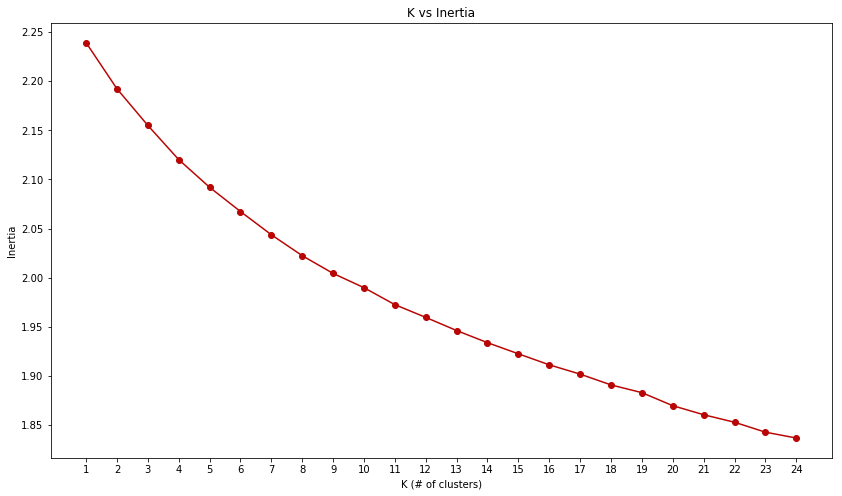

In [140]:
# Plot ks vs inertias
plot_inertias(1, 25, results5)

There is no clear elbow in this plot, even when testing up to 24 clusters. How will this effect our silhouette scores?

In [141]:
# compute silhouette scores
scores5 = sil_scores(2, 25, sim_matrix)

# display silhouette scores
print_scores(scores5)

k = 2 : 0.0221
k = 3 : 0.021
k = 4 : 0.0272
k = 5 : 0.0261
k = 6 : 0.029
k = 7 : 0.0181
k = 8 : 0.0178
k = 9 : 0.0216
k = 10 : 0.0177
k = 11 : 0.0196
k = 12 : 0.0255
k = 13 : 0.0226
k = 14 : 0.024
k = 15 : 0.0231
k = 16 : 0.0228
k = 17 : 0.022
k = 18 : 0.0254
k = 19 : 0.026
k = 20 : 0.0288
k = 21 : 0.0303
k = 22 : 0.0289
k = 23 : 0.03
k = 24 : 0.0227


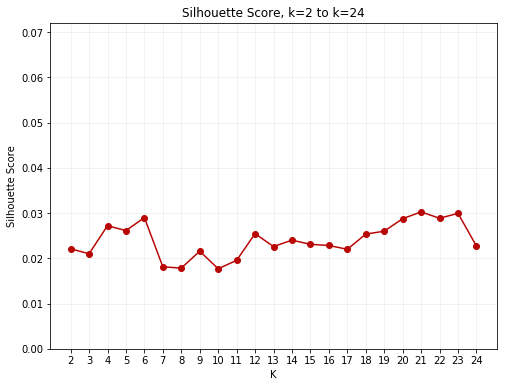

In [142]:
# plot silhouette scores
plot_sil_scores(scores5, 2, 25)

An interesting result. We get the highest silhouette score at k=17 in this range of k's. Let's see what some of the clusters look like.

In [143]:
# cluster counts for k=21
cluster_count_21 = compute_append_kmeans(21, recipe_titles_df, sim_matrix)
print(cluster_count_21)

    cluster21
0         575
1         869
2         432
3         209
4         356
5         176
6         325
7         888
8         146
9         262
10        258
11        385
12        148
13        172
14        375
15        253
16        251
17        235
18        423
19        763
20        440


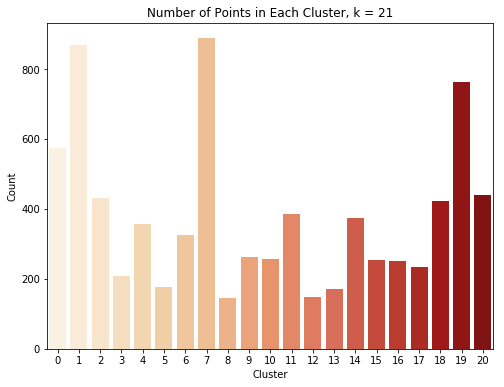

In [144]:
# plot histogram for k=21
cluster_hist(21, cluster_count_21)

In [145]:
# k=21, cluster=2
recipe_titles_df.loc[recipe_titles_df['cluster21'] == 2].head(10)[['cluster21']]

,cluster21
Mahi-Mahi in Tomato Olive Sauce,2
Turkey and Pinto Bean Chili,2
Chocolate-Cherry Ice Cream Pie with Hot Fudge Sauce,2
Chili Meatballs in Black Bean and Tomato Sauce,2
"Linguine with Sausage, Mushroom and Cream Sauce",2
Lemon Ice Cream with Black-Currant Sauce,2
Panna Cotta with Crushed Raspberry Sauce,2
Tatemado de Costilla de Res (Tatemado Short Ribs),2
Tamarind-Glazed Turkey Burgers,2
Beef and Broccoli Wontons with Ginger Dipping Sauce,2


In [146]:
# k=21, cluster=14
recipe_titles_df.loc[recipe_titles_df['cluster21'] == 14].head(10)[['cluster21']]

,cluster21
White Chocolate Tartlets with Strawberries and Bananas,14
Banana Split with Curried Chocolate-Coconut Sauce,14
Dark Chocolate Wedding Cake with Chocolate Orange Ganache and Orange Buttercream,14
Chocolate Pecan Banana Tarts,14
Sour Cream Apple Pie,14
Chocolate Semifreddo with Chile-Chocolate Sauce,14
Chocolate Pecan Layer Cake,14
Chocolate Pecan Cake,14
Bittersweet Chocolate-Citrus Tart with Jasmine Whipped Cream,14
Giant Chocolate Candy Bar With Peanuts and Nougat,14


We can see some clear types of recipes falling into each cluster. Let's see if we can visualize this.

In [147]:
# build dataframe
pca_df21 = pd.DataFrame(np.matrix(pca.fit_transform(sim_matrix)), columns=['x','y'])
recipe_titles_df['x21'], recipe_titles_df['y21'] = pca_df21.loc[:,'x'], pca_df21.loc[:,'y']

pca_df21.head()

,x,y
0,-0.003968,0.003300
1,0.004725,-0.001935
2,-0.002656,-0.005010
3,0.000974,0.000335
4,-0.000348,-0.003884


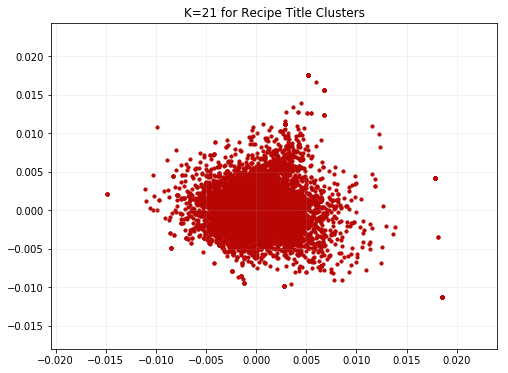

In [148]:
# plot clusters without cluster colors
fig = plt.figure(figsize = (8,6))
plt.scatter(x = pca_df21.loc[:,'x'], y = pca_df21.loc[:,'y'], s = 10)
plt.title('K=21 for Recipe Title Clusters')
plt.grid(True, alpha=.2)

In [149]:
color_map_21 = plt.get_cmap('OrRd_r')

colors21 = color_map_21(np.linspace(0, .9, 21))
print(colors21)

[[0.49803922 0.         0.         1.        ]
 [0.56841215 0.         0.         1.        ]
 [0.64518262 0.         0.         1.        ]
 [0.71137255 0.01254902 0.00810458 1.        ]
 [0.76452134 0.08341407 0.05387159 1.        ]
 [0.81324106 0.1483737  0.09582468 1.        ]
 [0.85863899 0.22246828 0.14805075 1.        ]
 [0.8911188  0.29419454 0.2035371  1.        ]
 [0.92655133 0.37244137 0.26406767 1.        ]
 [0.94905037 0.43237216 0.29777778 1.        ]
 [0.96824298 0.49142637 0.32287582 1.        ]
 [0.98583622 0.5455594  0.34588235 1.        ]
 [0.9895271  0.61236448 0.40456747 1.        ]
 [0.99088043 0.67461745 0.46276048 1.        ]
 [0.99215686 0.73833141 0.52284506 1.        ]
 [0.99215686 0.77216455 0.55803153 1.        ]
 [0.99215686 0.80907343 0.59641676 1.        ]
 [0.99261822 0.84059977 0.63898501 1.        ]
 [0.99409458 0.87012687 0.70099193 1.        ]
 [0.9954479  0.89719339 0.7578316  1.        ]
 [0.99692426 0.92249135 0.81476355 1.        ]]


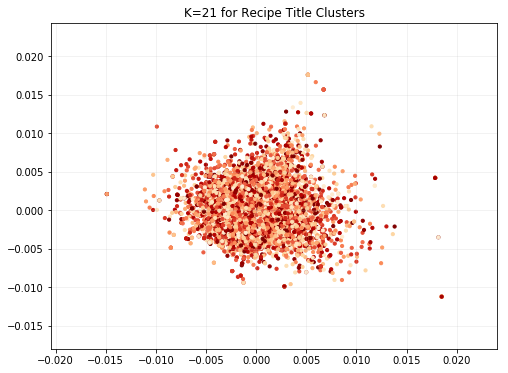

In [150]:
# plot clusters without cluster colors
fig = plt.figure(figsize = (8,6))
plt.scatter(x = pca_df21.loc[:,'x'], y = pca_df21.loc[:,'y'], s = 10, c=colors21)
plt.title('K=21 for Recipe Title Clusters')
plt.grid(True, alpha=.2)